In [188]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [3]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData/'

In [180]:
def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][chr]])
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def tcga_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_meta[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_meta[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    df = tcga_meta.reindex([x.split('_')[0].split('-')[-1] for x in tcga_samples['samples']])
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = [i.split('>')[-1] for i in chromosome_layer['index'][chr]]
        conditions[chr] = df.loc[samples][' Project'].apply(lambda x: mapping[x.split('-')[-1]]).values
        annotations[chr] = ann
    return conditions, annotations
    
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

def save_correlation(omic, layers, resolution, chr='all', path=".", cmp_method='sim'):
    metrs = ['score', 'pvalue']
    if chr=='all':
        chr=ca.info.CHROMOSOMES['names']
    if not isinstance(chr, list):
        chr = [chr]
    for c in chr:
        path = os.path.join(path, cmp_method+f'/{c}')
        if not os.path.exists(path):
            os.makedirs(path)
        for m in metrs:
            for k, v in omic.layers[resolution]['co'][tuple(sorted(set(layers)))][cmp_method][c][m].items():
                v.to_csv(f'{path}/{c}_{k}_{m}.csv')
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].apply(lambda x:x.split('TCGA-')[-1]).values[0]}_{name}"

def copy_files_to_subdirectory(file_list, parent_directory, sub_directory):
    # Create the subdirectory path
    sub_directory_path = os.path.join(parent_directory, sub_directory)

    # Create the subdirectory if it doesn't exist
    if not os.path.exists(sub_directory_path):
        os.makedirs(sub_directory_path)

    # Copy each file from the parent directory to the subdirectory
    for file in file_list:
        source_path = os.path.join(parent_directory, file)
        destination_path = os.path.join(sub_directory_path, file)

        # Check if the file exists in the parent directory
        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path)
            print(f"Copied {file} to {sub_directory}")
        else:
            print(f"File not found: {file}")

# Example usage
# file_names = ['file1.txt', 'file2.txt']
# parent_dir = '/path/to/parent/directory'
# sub_dir_name = 'my_subdirectory'
# copy_files_to_subdirectory(file_names, parent_dir, sub_dir_name)


In [5]:
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[c] = ann
    return conditions, annotations

In [6]:
def cnv_gain(matrix):
    m = matrix.copy()
    m[m<=2]=0
    m[m!=0]=1
    return m
def cnv_loss(matrix):
    m = matrix.copy()
    m[m>=2]=0
    m[m!=0]=1
    return m

In [7]:
def cote_present(matrix):
    matrix = matrix.copy()
    matrix[matrix>0]=1
    return matrix

### TE and COTEs

In [176]:
ind = IntData()
# ind.add_layer("TCGA_ATAC", input='/cluster/projects/lupiengroup/People/mossi/data/TCGA/ATAC', resolution=resolution)

ind.add_layer("TEs", resolutions=[1e04], input=parent_dir+'/data/V2-TEs/non_olap', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs",  resolutions=[1e04],input=parent_dir+'/data/V2-TEs/non_olap/cores1000', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.chr.add_filter('COTE', Clustered_TEs, ['TEs'], resolutions=[1e04],)

loading files from: /Users/mossishahi/Code/lupien/IntData//data/V2-TEs/non_olap


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:35<00:00, 27.54it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData//data/V2-TEs/non_olap/cores1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:12<00:00, 36.82it/s]


In [191]:
ind.add_layer("TCGA",  resolutions=[1e04], 
              input=parent_dir+'/data/TCGA/filtered_TCGA', 
              index_mapper=lambda x: x.split('_')[0].split('-')[-1],
             feature_type='signal',
             overlap_method='max',
             feature_column=4)

loading files from: /Users/mossishahi/Code/lupien/IntData//data/TCGA/filtered_TCGA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [03:35<00:00,  2.02it/s]


In [192]:
files = [i.split('_peaks.')[0] for i in os.listdir(parent_dir+'/data/TCGA/filtered_TCGA/') if i.endswith('.bed')]

In [193]:
tcga_meta = pd.read_csv(parent_dir+'/data/TCGA/GDC_identifiers_no_duplicates.tsv', sep='\t')
tcga_samples = pd.DataFrame(files, columns=['samples'])
tcga_meta['id'] = tcga_meta['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])
tcga_meta = tcga_meta.set_index('id')
df=tcga_meta.reindex([x.split('_')[0].split('-')[-1] for x in tcga_samples['samples']])

In [194]:
ind.chr.add_filter('cancertype', tcga_cancertype, ['TCGA'], resolutions=[1e04])

In [120]:
ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e06, 1e07],)
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/CNVAR/segments/beds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:24<00:00,  3.50s/it]


figure saved at /Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 4/figure.png


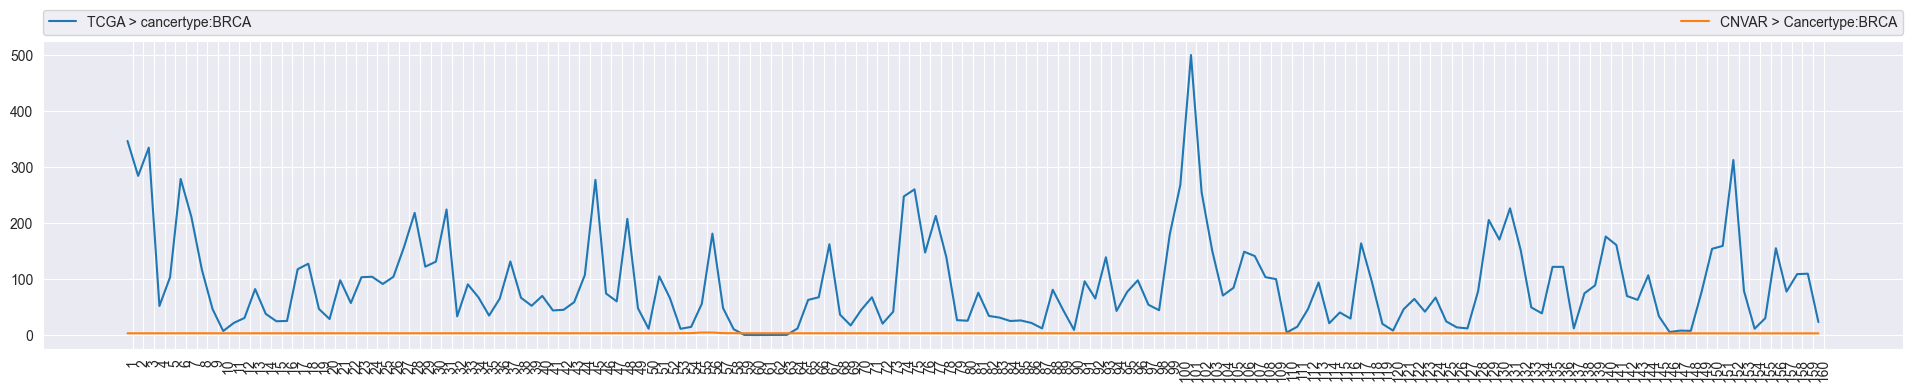

In [234]:
ca.pl.match_layers(ind.chr, ['TCGA', 'CNVAR'], groups={'CNVAR':{'Cancertype':'BRCA'}, 'TCGA':{'cancertype':'BRCA'}}, 
                   chrom='chr7', 
                   qnormalize=False, 
                   normal_y=False,
                  save_fig='BRCA_TCGA_CNV.png', 
                   aggregation='mean',
                  path='/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 4/', 
                  reverse_filter=True)

In [181]:
f = ind.chr.get_layer('CNVAR', groups={'Cancertype':'GBM'}, chrom='chr7')
d = f['Cancertype:GBM']['data']
nf = ind.chr.get_layer('CNVAR', groups={'Cancertype':'GBM'}, chrom='chr7', reverse_filter=True)
nd = nf['Cancertype:GBM']['data']
df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T]), index=[f'GBM: {d.shape[0]} samples', f'Other cancer types: {nd.shape[0]} samples']).T
plt.figure(figsize=(24, 4))
plt.title('Copy Number variation across chromosome 7', fontsize=14)
plt.xlabel('Mega Base Pairs (MBP)')
plt.ylabel('Average of Copy Numbers')
plt.xticks(np.arange(0, d.shape[1], 5))
plt.yticks(fontsize=8)
sns.lineplot(df)
plt.savefig('GBM_cnvar_chr7.png', bbox_inches='tight')
plt.show()

KeyError: 'CNVAR'

In [112]:
f = ind.chr.get_layer('TCGA', groups={'cancertype':ct.split('-')[-1]}, chrom='chr8', resolution=1e05)
# x = f[f'cancertype:{ct.split('-')[-1]}']['index']
# files = [tcga_samples.loc[tcga_samples['samples'].apply(lambda x: i.split('>')[-1] in x)].values[0][0]+'_peaks.narrowPeak.bed' for i in x]
# copy_files_to_subdirectory(files, tcga_dir, ct)
d = f[f'cancertype:{ct.split('-')[-1]}']['data']

In [182]:
resolution = 1e04
window = 100
gene_bp = 127735434
gene_locus = int(gene_bp//resolution)
# - - - - - - - -
start = gene_locus - int(window/2)
end = gene_locus + int(window/2)

  0%|                                                                                                                                | 0/23 [00:00<?, ?it/s]

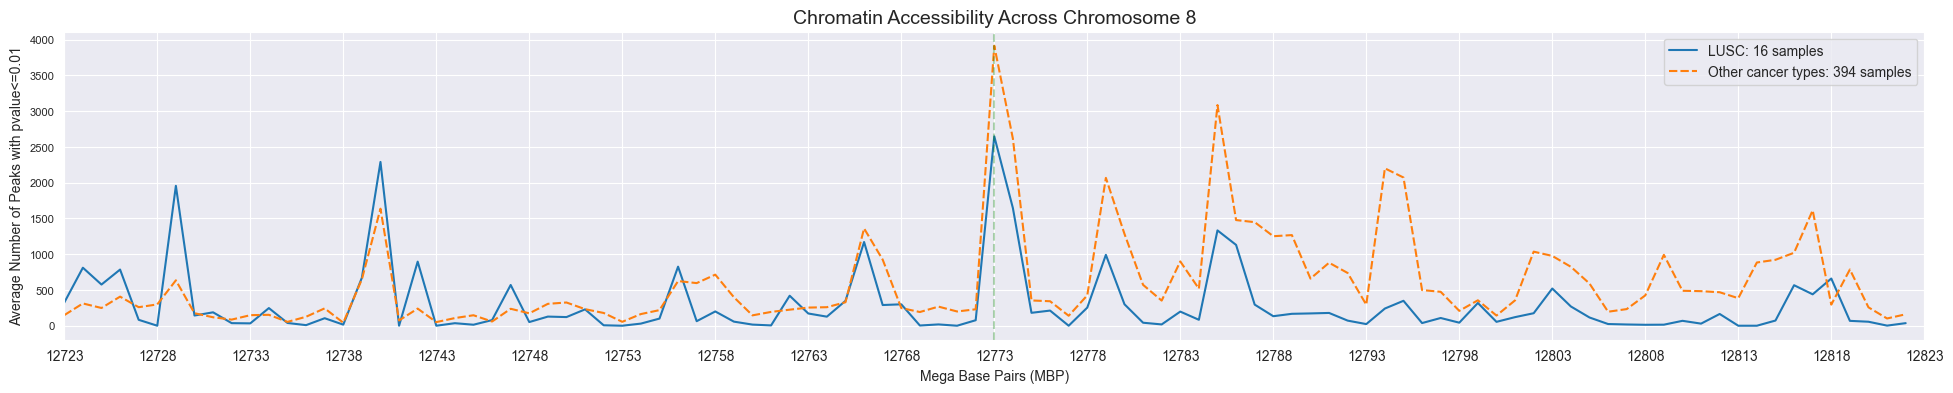

  4%|█████▏                                                                                                                  | 1/23 [00:00<00:06,  3.18it/s]

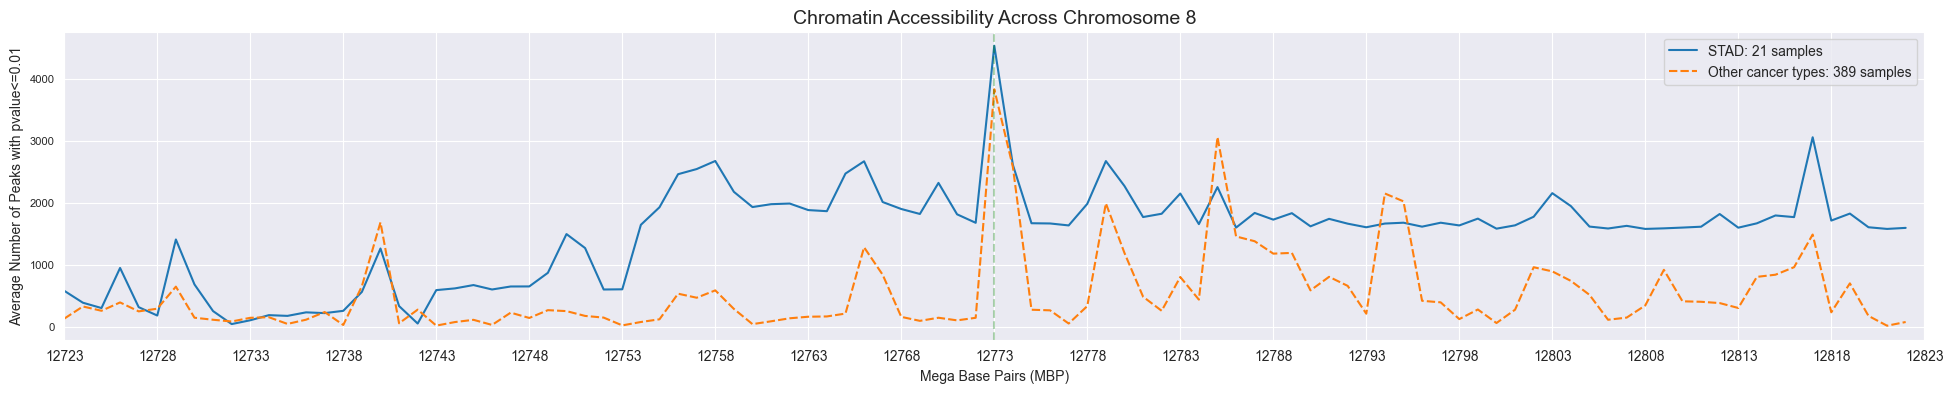

  9%|██████████▍                                                                                                             | 2/23 [00:00<00:06,  3.31it/s]

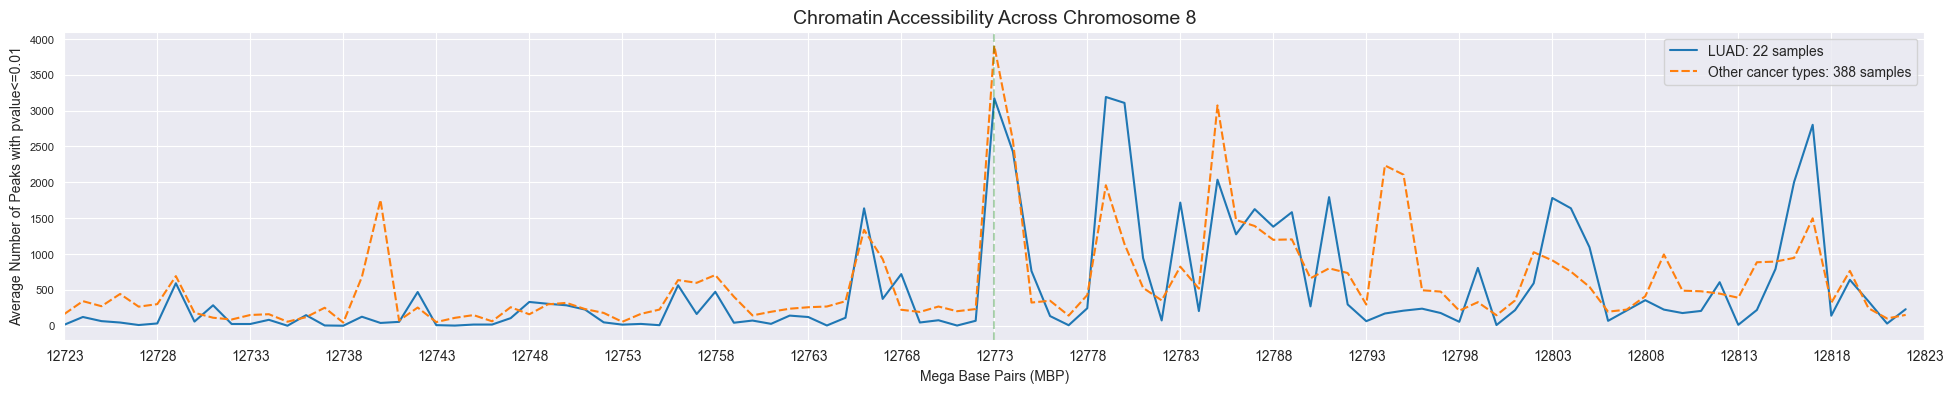

 13%|███████████████▋                                                                                                        | 3/23 [00:00<00:06,  3.32it/s]

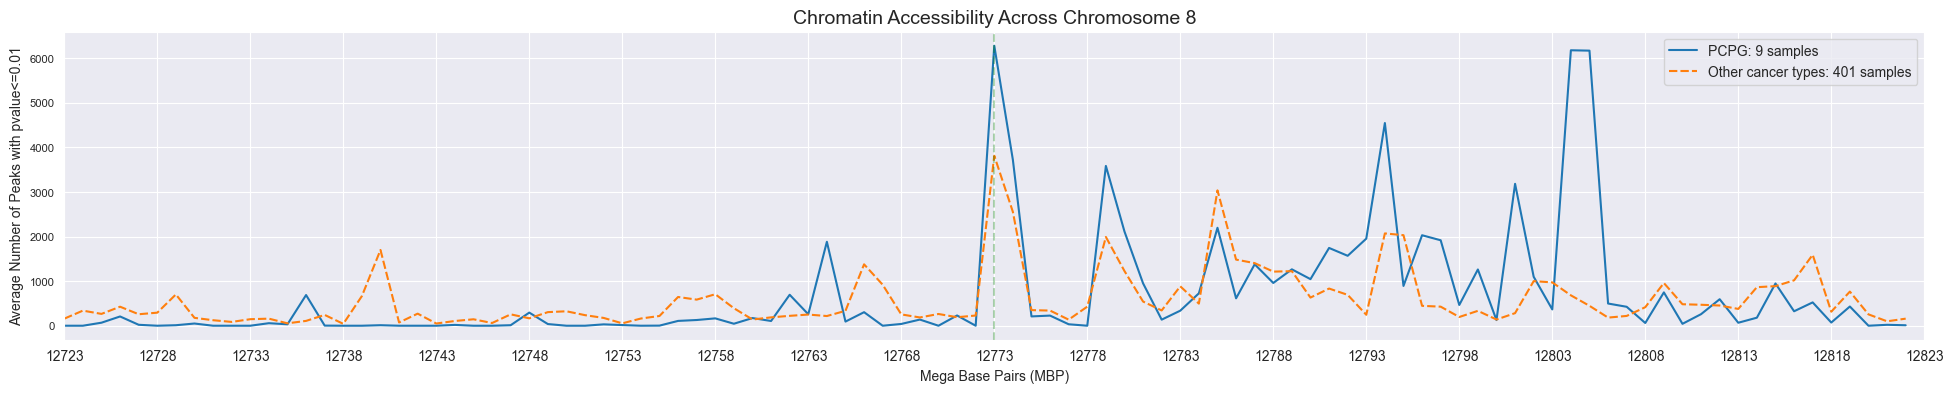

 17%|████████████████████▊                                                                                                   | 4/23 [00:01<00:05,  3.37it/s]

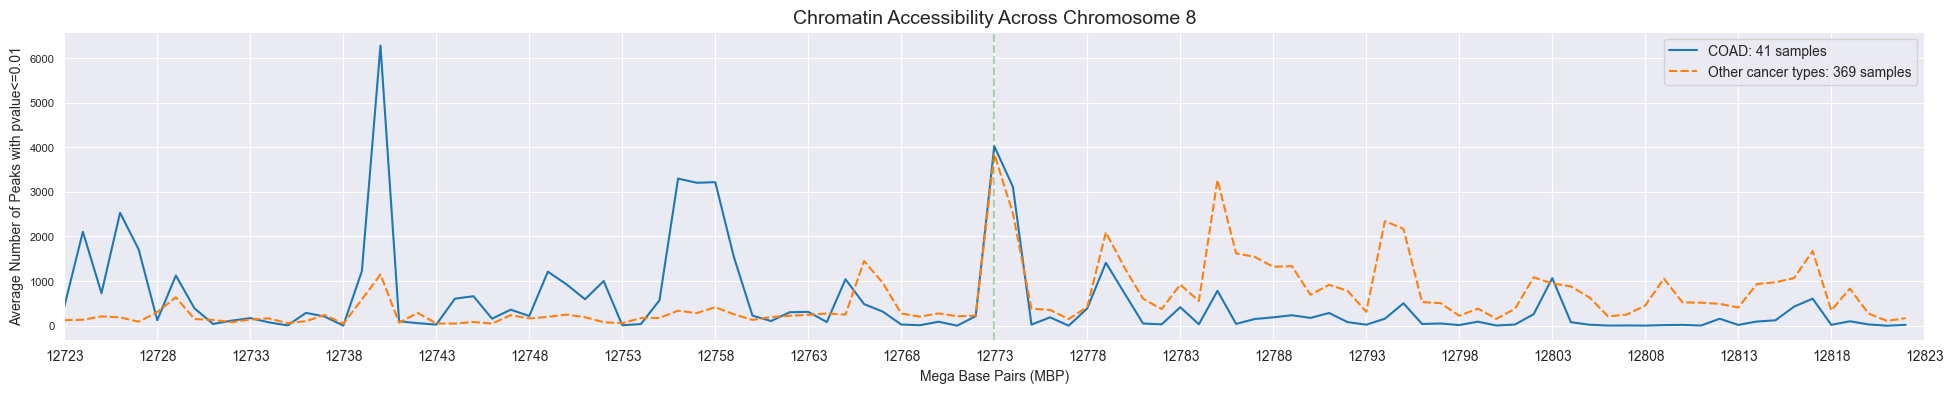

 22%|██████████████████████████                                                                                              | 5/23 [00:01<00:05,  3.36it/s]

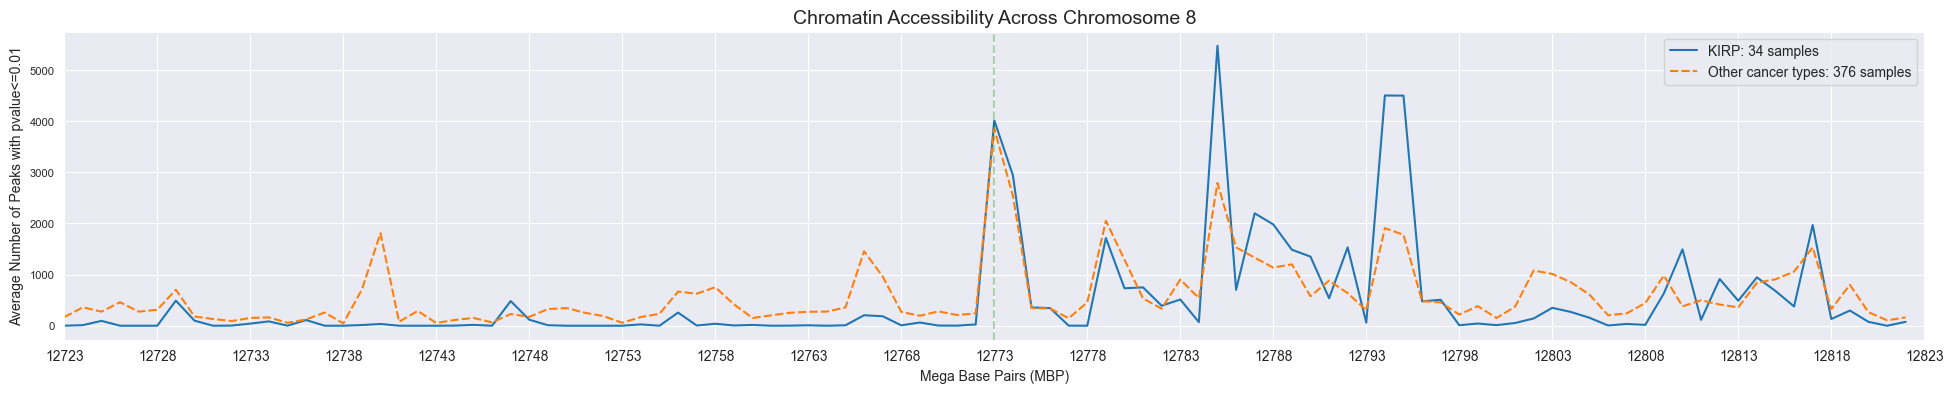

 26%|███████████████████████████████▎                                                                                        | 6/23 [00:01<00:05,  3.38it/s]

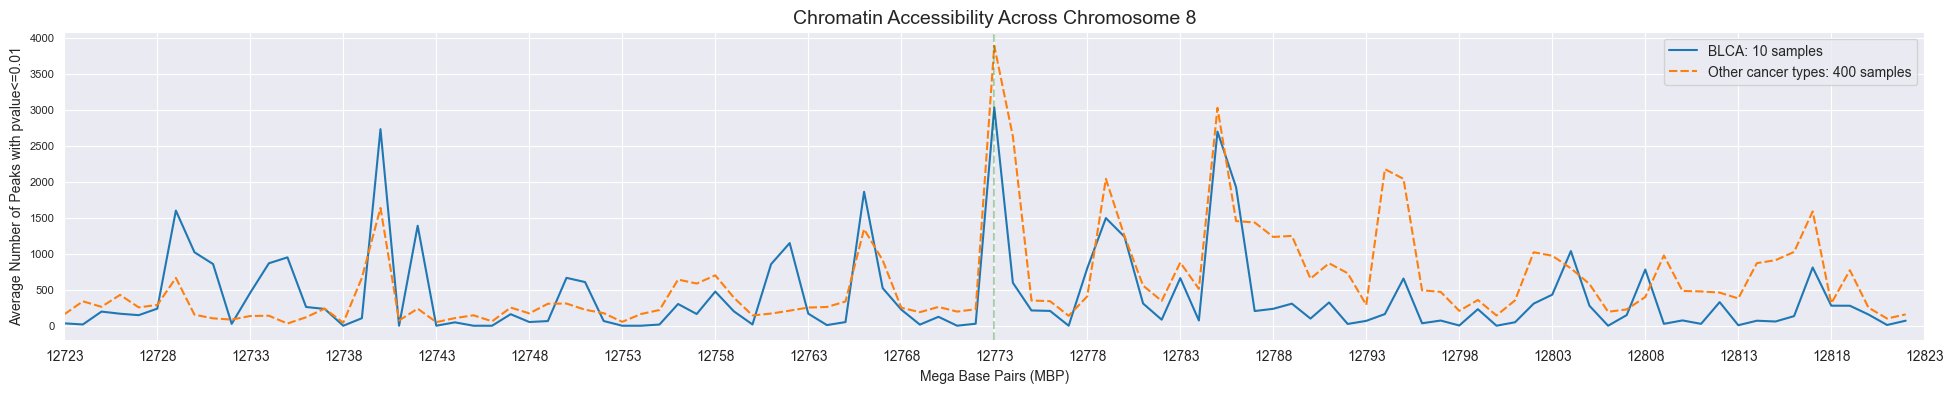

 30%|████████████████████████████████████▌                                                                                   | 7/23 [00:02<00:04,  3.35it/s]

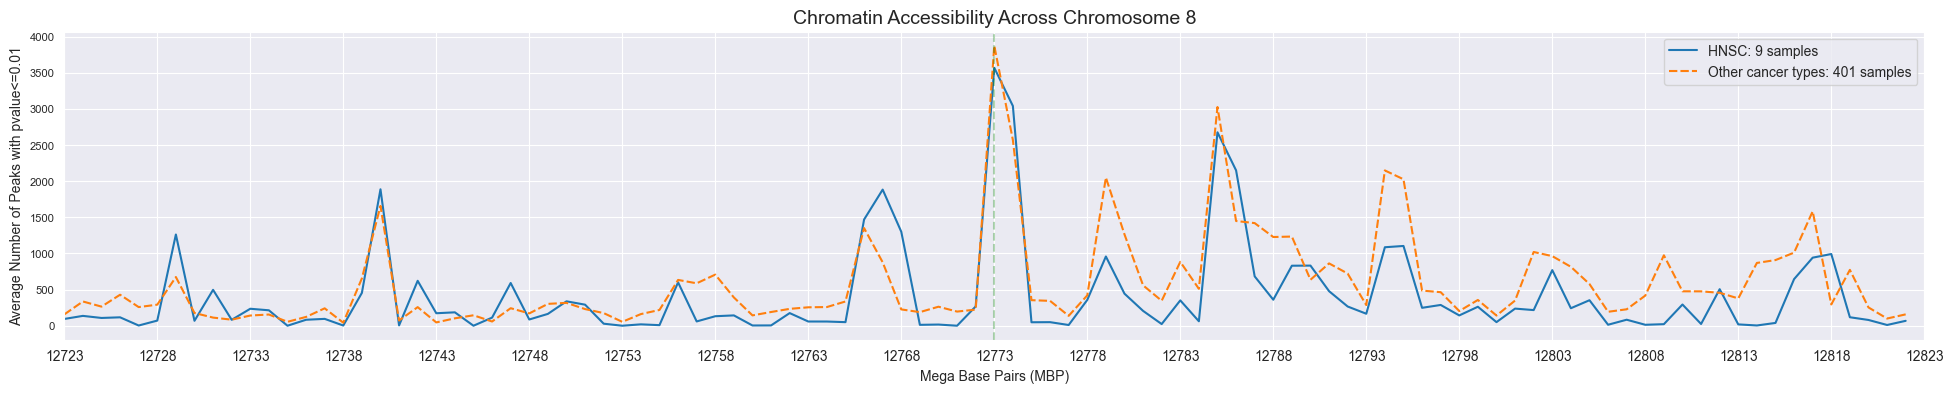

 35%|█████████████████████████████████████████▋                                                                              | 8/23 [00:02<00:04,  3.38it/s]

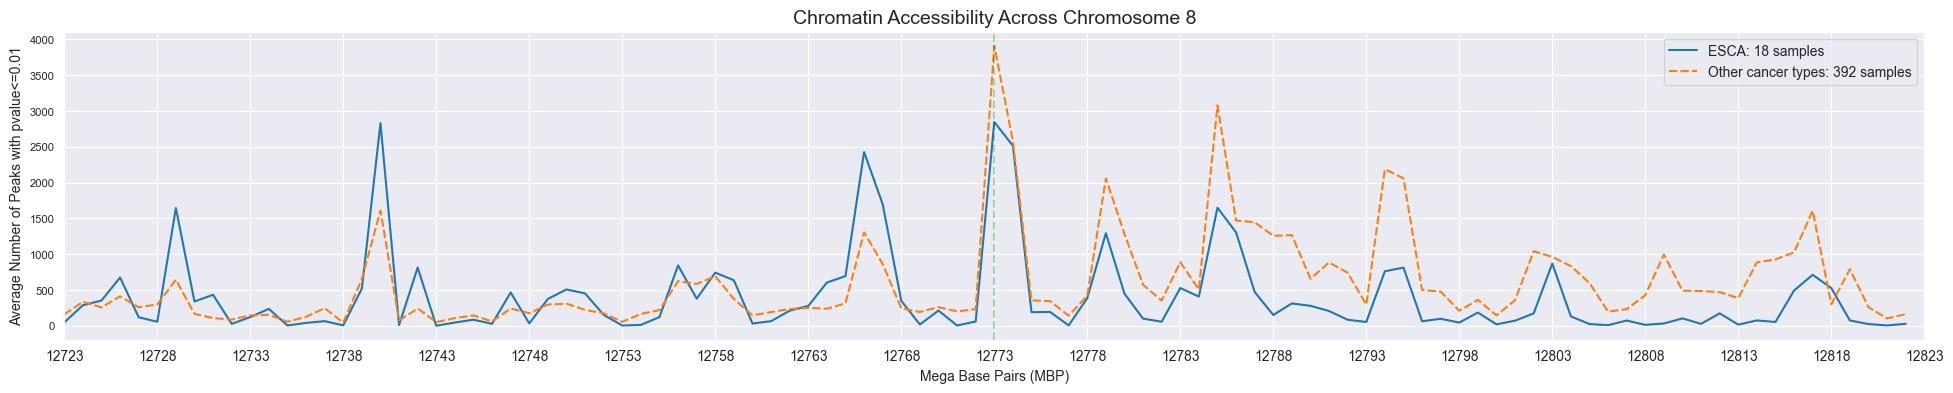

 39%|██████████████████████████████████████████████▉                                                                         | 9/23 [00:02<00:04,  3.40it/s]

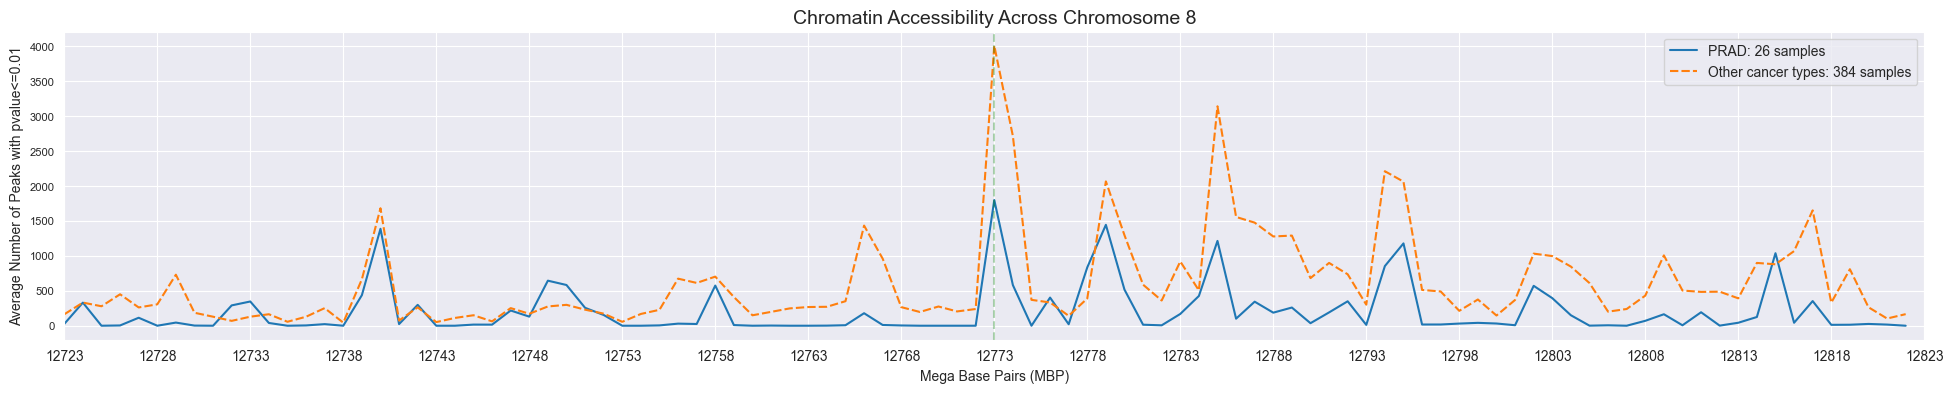

 43%|███████████████████████████████████████████████████▋                                                                   | 10/23 [00:02<00:03,  3.41it/s]

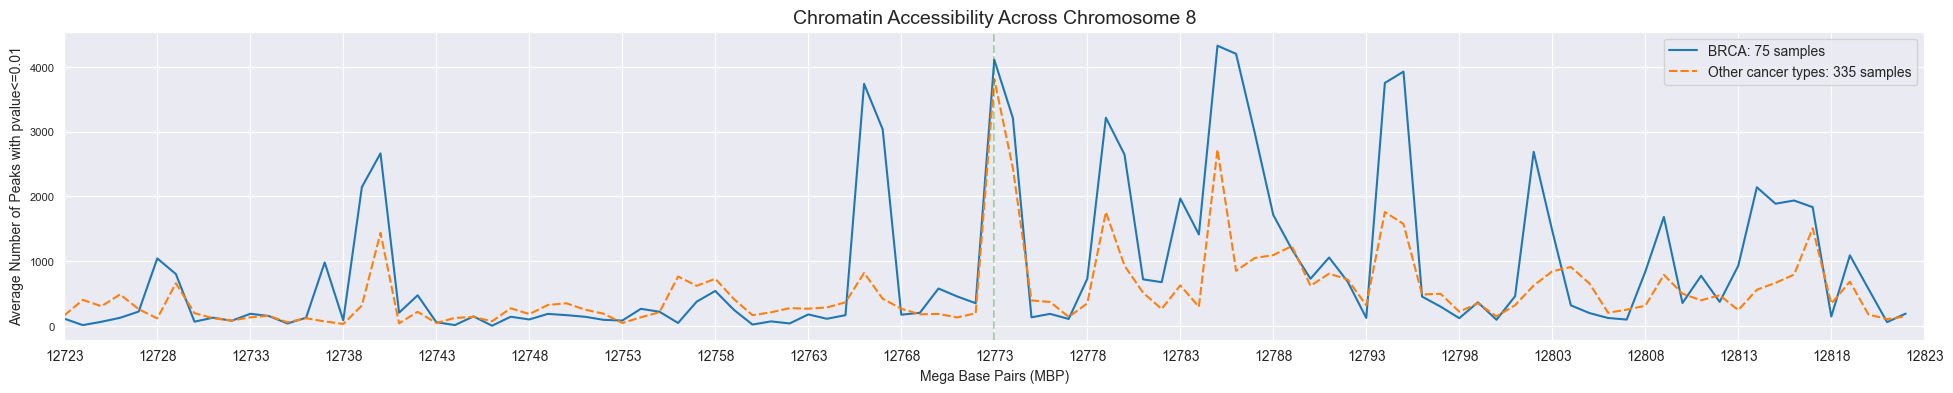

 48%|████████████████████████████████████████████████████████▉                                                              | 11/23 [00:03<00:03,  3.43it/s]

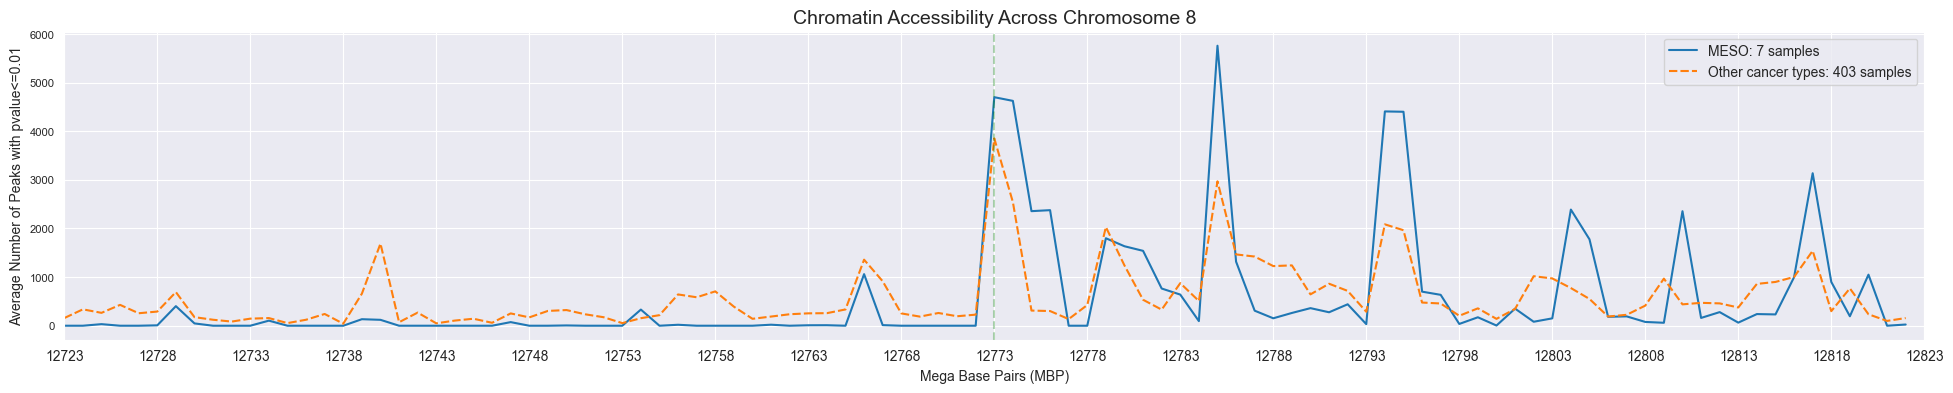

 52%|██████████████████████████████████████████████████████████████                                                         | 12/23 [00:03<00:03,  3.45it/s]

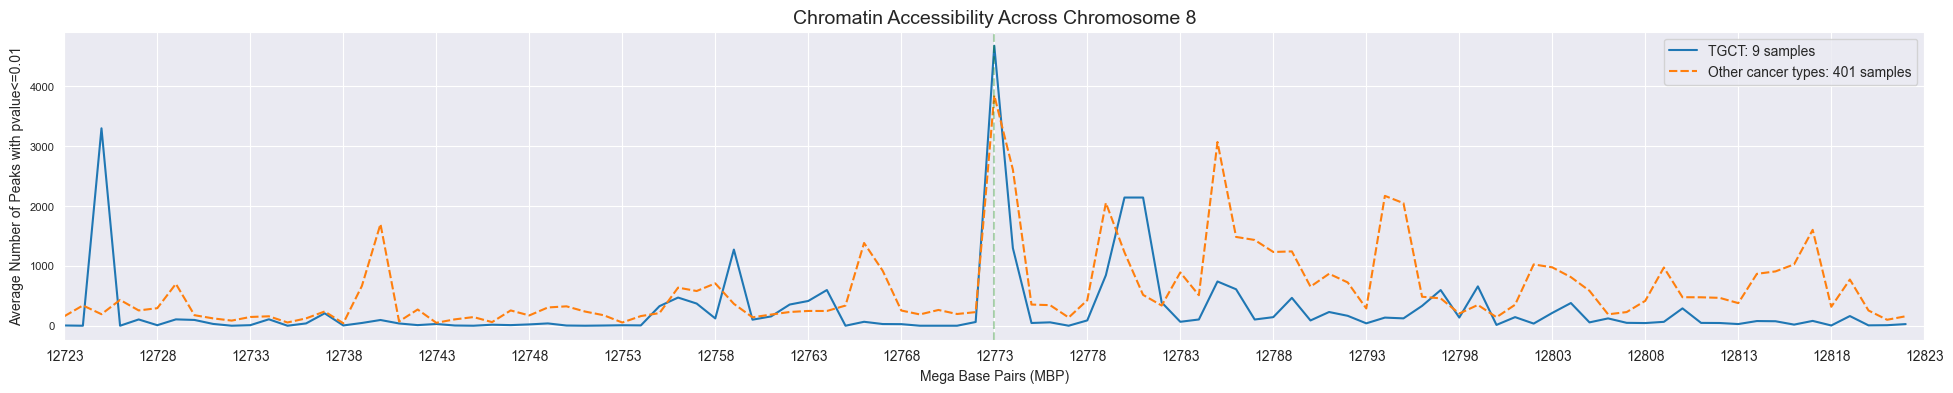

 57%|███████████████████████████████████████████████████████████████████▎                                                   | 13/23 [00:03<00:02,  3.50it/s]

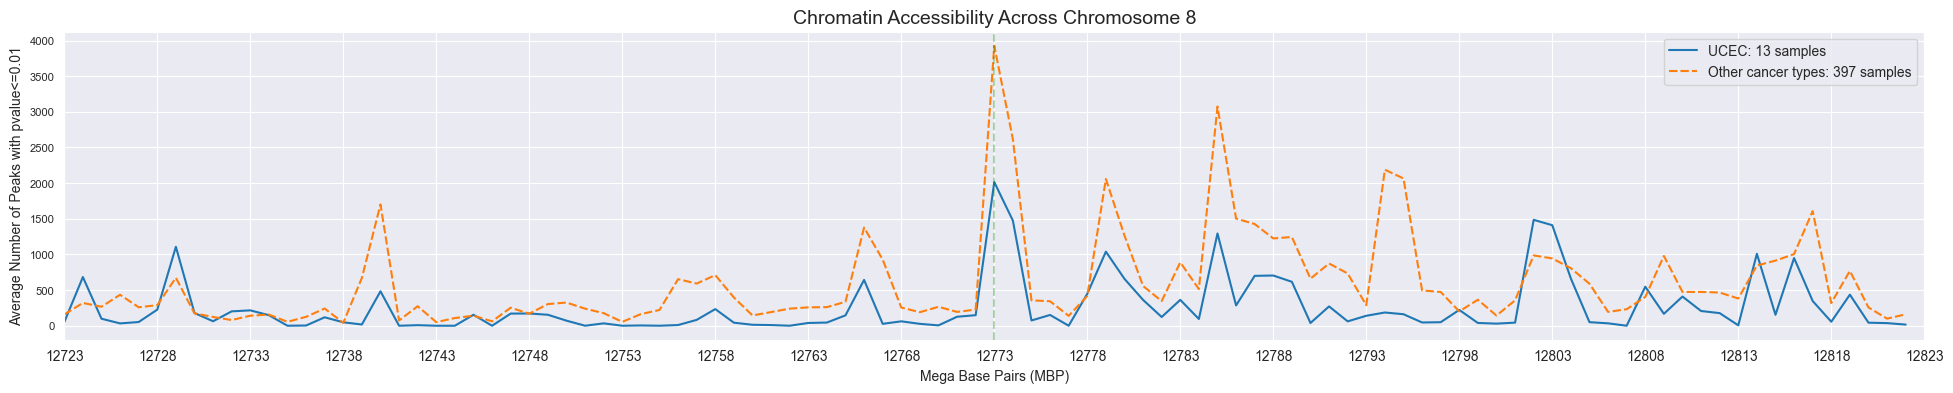

 61%|████████████████████████████████████████████████████████████████████████▍                                              | 14/23 [00:04<00:02,  3.48it/s]

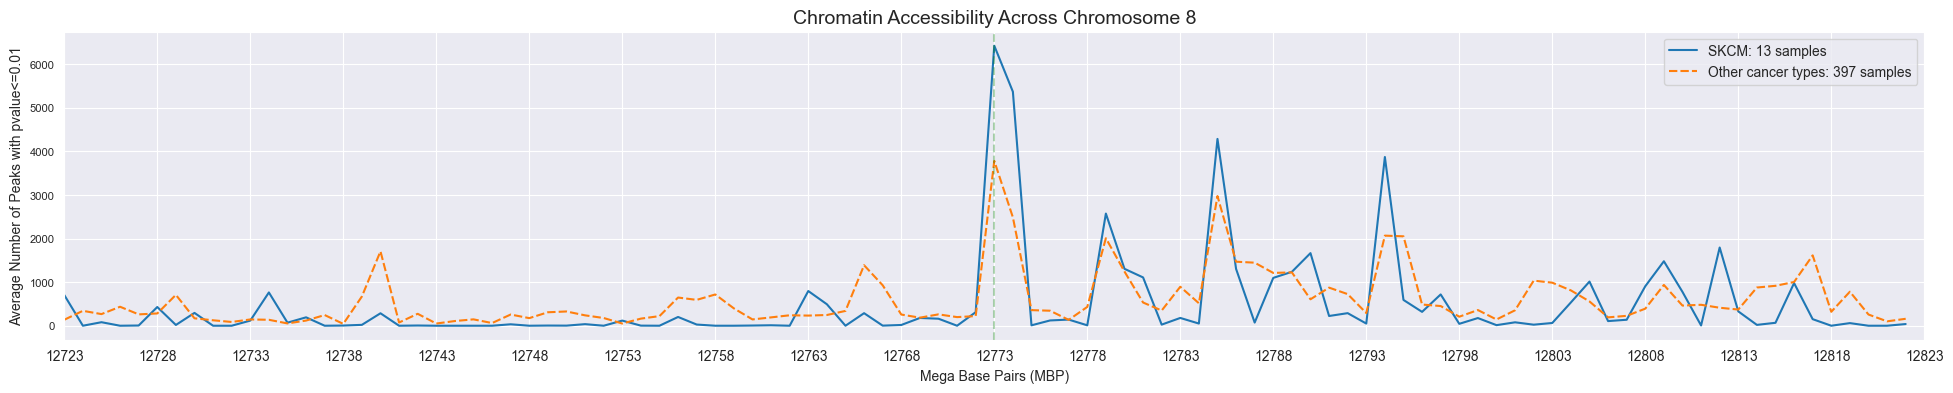

 65%|█████████████████████████████████████████████████████████████████████████████▌                                         | 15/23 [00:04<00:02,  3.51it/s]

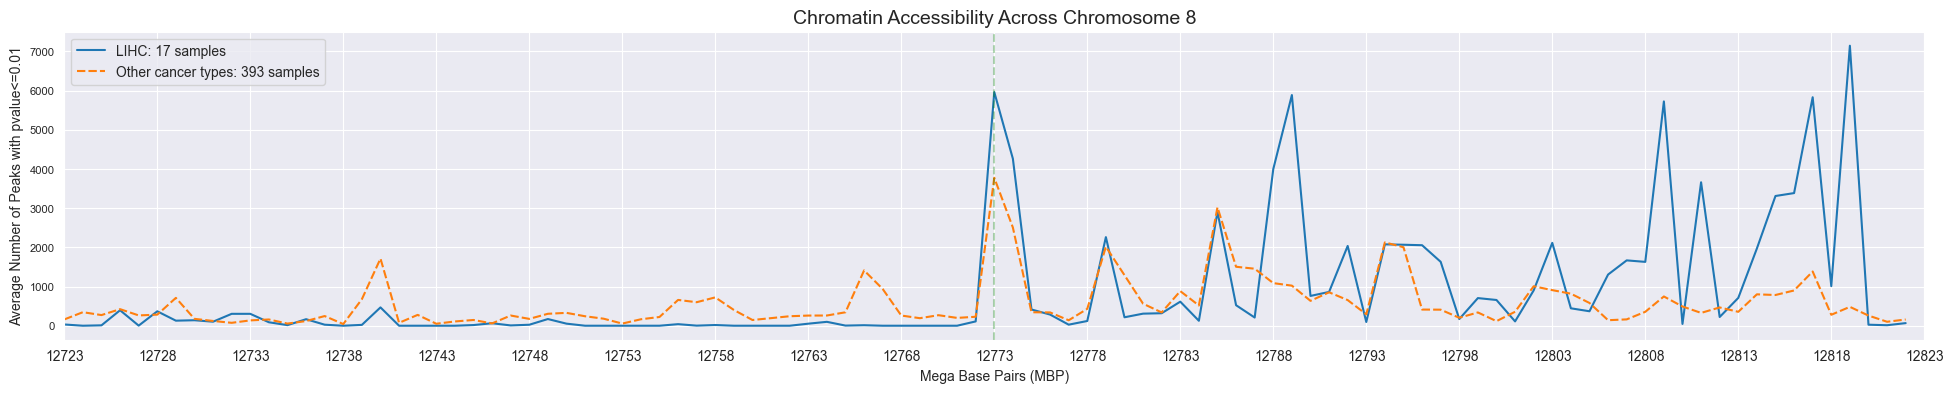

 70%|██████████████████████████████████████████████████████████████████████████████████▊                                    | 16/23 [00:04<00:01,  3.51it/s]

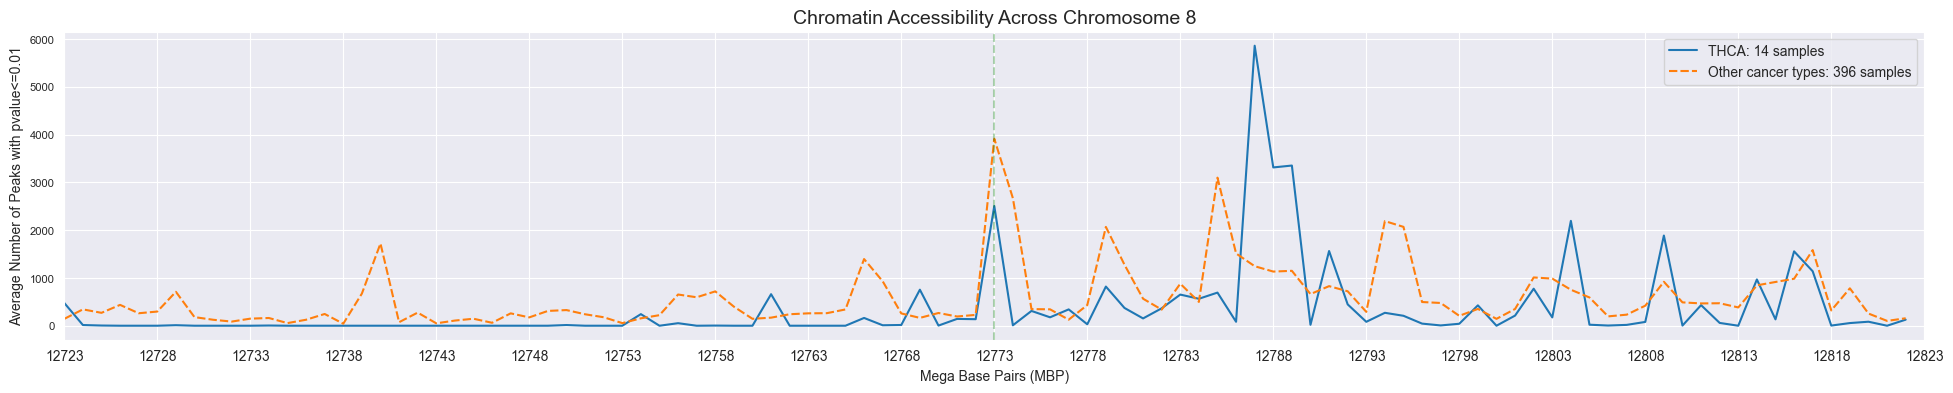

 74%|███████████████████████████████████████████████████████████████████████████████████████▉                               | 17/23 [00:04<00:01,  3.54it/s]

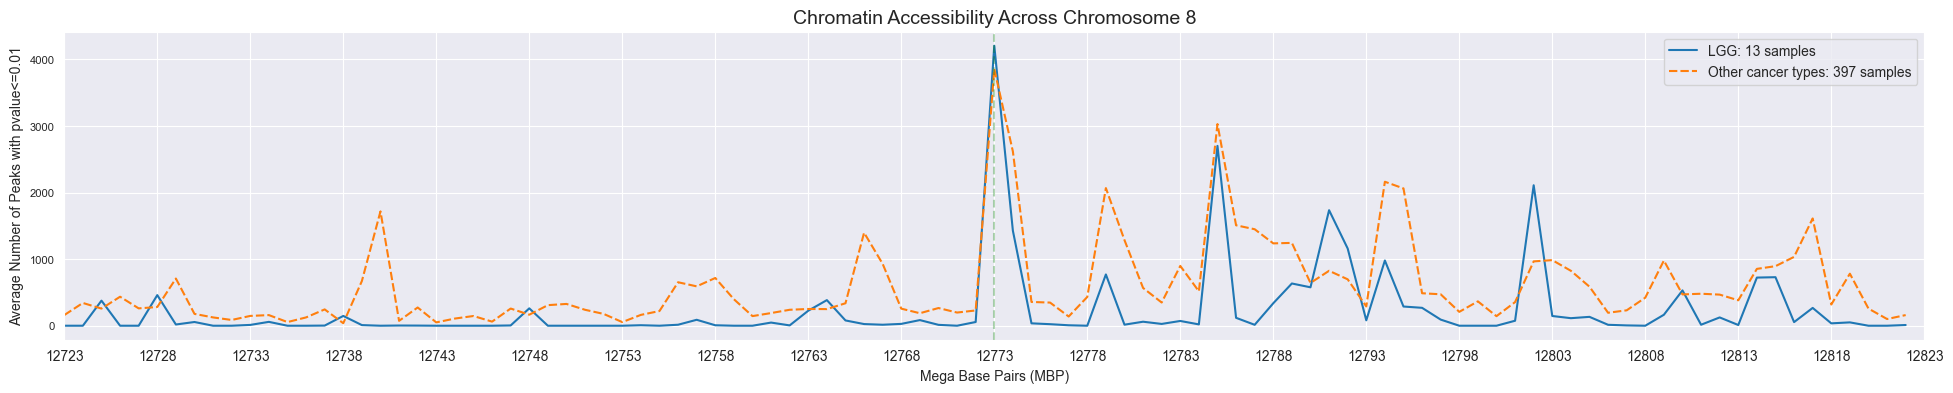

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                         | 18/23 [00:05<00:01,  3.55it/s]

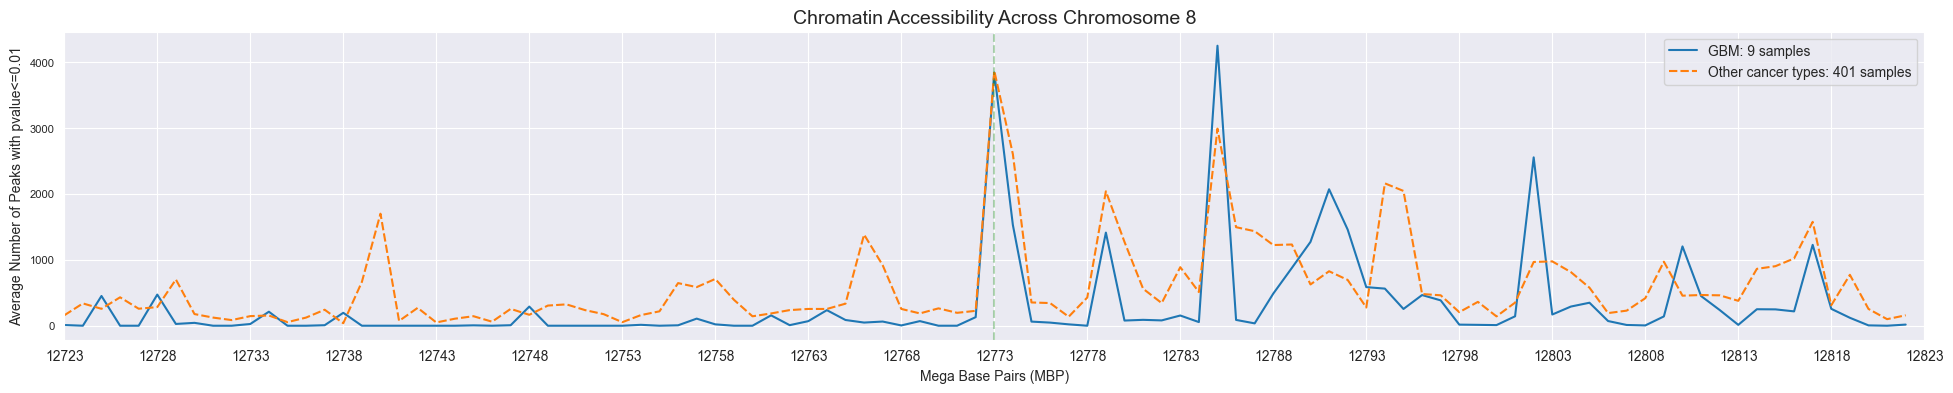

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 19/23 [00:05<00:01,  3.55it/s]

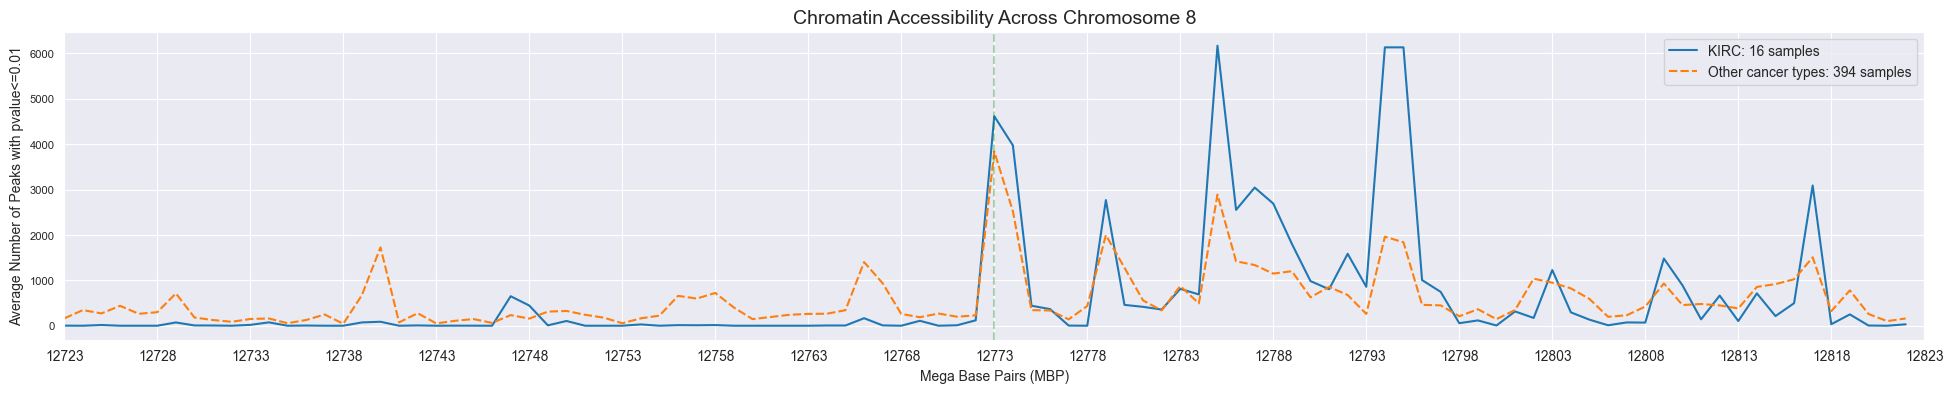

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 20/23 [00:05<00:00,  3.55it/s]

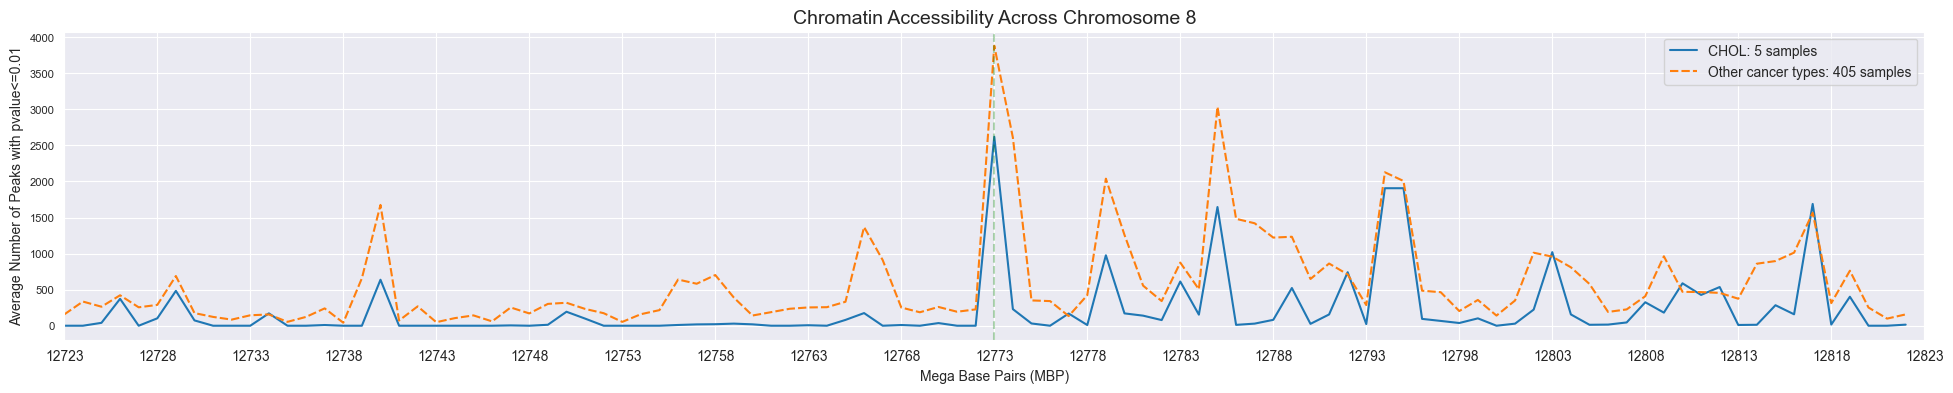

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 21/23 [00:06<00:00,  3.49it/s]

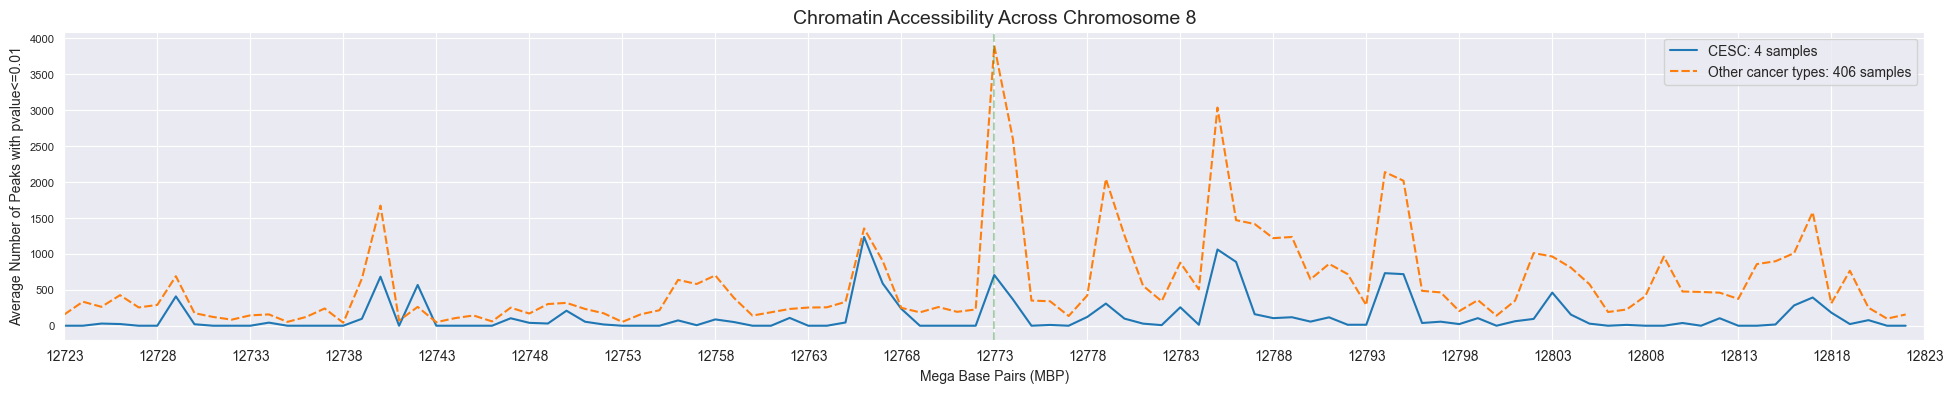

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 22/23 [00:06<00:00,  3.48it/s]

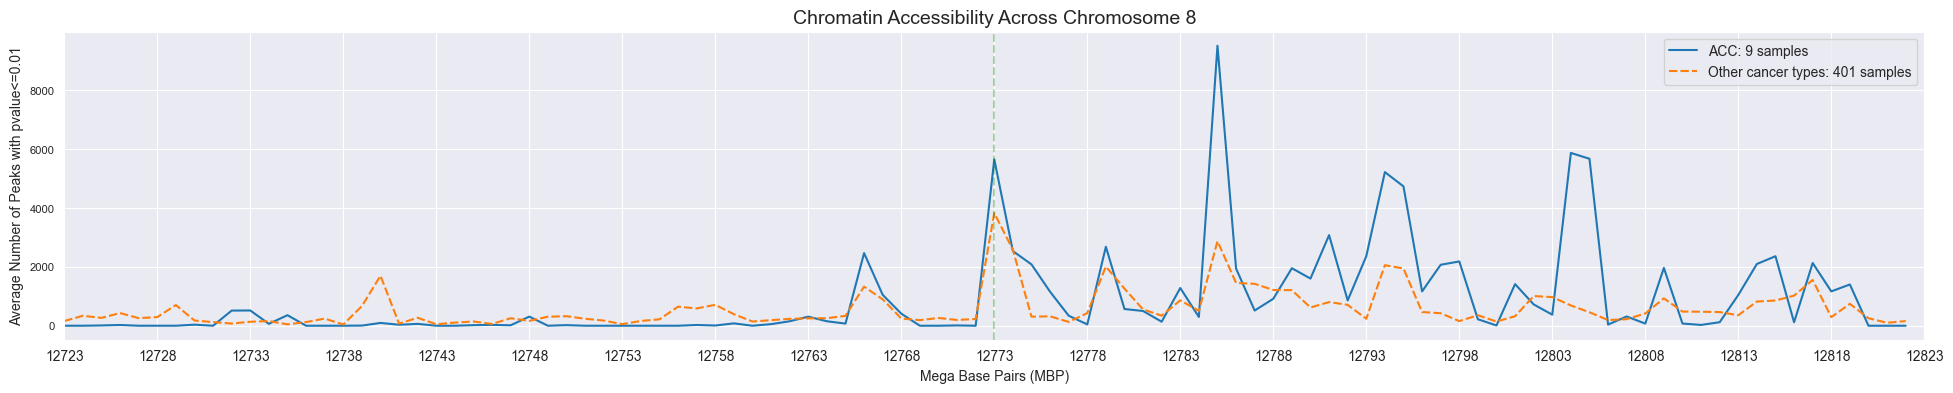

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.46it/s]


In [195]:
for ct in tqdm(tcga_meta[' Project'].unique()):
    f = ind.chr.get_layer('TCGA', groups={'cancertype':ct.split('-')[-1]}, chrom='chr8', resolution=1e04)
    d = f[f'cancertype:{ct.split('-')[-1]}']['data'][:, start:end]
    nf = ind.chr.get_layer('TCGA', groups={'cancertype':ct.split('-')[-1]}, chrom='chr8', reverse_filter=True, resolution=1e04)
    nd = nf[f'cancertype:{ct.split('-')[-1]}']['data'][:, start:end]
    df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T]), index=[f'{ct.split('-')[-1]}: {d.shape[0]} samples', f'Other cancer types: {nd.shape[0]} samples']).T
    df = df.set_index(np.arange(start, end))
    plt.figure(figsize=(24, 4))
    plt.title('Chromatin Accessibility Across Chromosome 8', fontsize=14)
    plt.xlabel('Mega Base Pairs (MBP)')
    plt.ylabel('Average Number of Peaks with pvalue<=0.01')
    plt.yticks(fontsize=8)
    sns.lineplot(df)
    plt.axvline(x=gene_locus, color='g', linestyle='--', alpha=0.3)
    plt.xlim(start, end)  # Replace start_value with the actual start value of your data
    plt.xticks(np.arange(start, end+1, 5))
    plt.savefig(f'{ct.split('-')[-1]}_atac_chr8.png', bbox_inches='tight')
    plt.show()

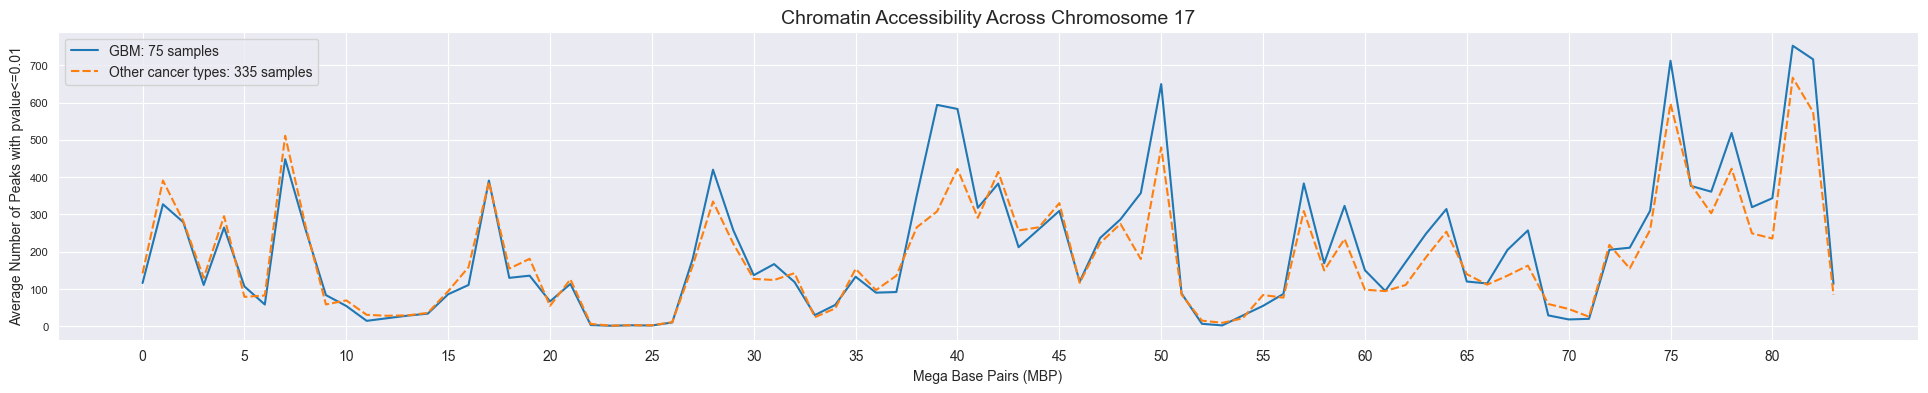

In [294]:
f = ind.chr.get_layer('TCGA', groups={'cancertype':'BRCA'}, chrom='chr17')
d = f['cancertype:BRCA']['data']
nf = ind.chr.get_layer('TCGA', groups={'cancertype':'BRCA'}, chrom='chr17', reverse_filter=True)
nd = nf['cancertype:BRCA']['data']
df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T]), index=[f'GBM: {d.shape[0]} samples', f'Other cancer types: {nd.shape[0]} samples']).T
plt.figure(figsize=(24, 4))
plt.title('Chromatin Accessibility Across Chromosome 17', fontsize=14)
plt.xlabel('Mega Base Pairs (MBP)')
plt.ylabel('Average Number of Peaks with pvalue<=0.01')
plt.xticks(np.arange(0, d.shape[1], 5))
plt.yticks(fontsize=8)
sns.lineplot(df)
plt.savefig('BRCA_atac_chr17.png', bbox_inches='tight')
plt.show()

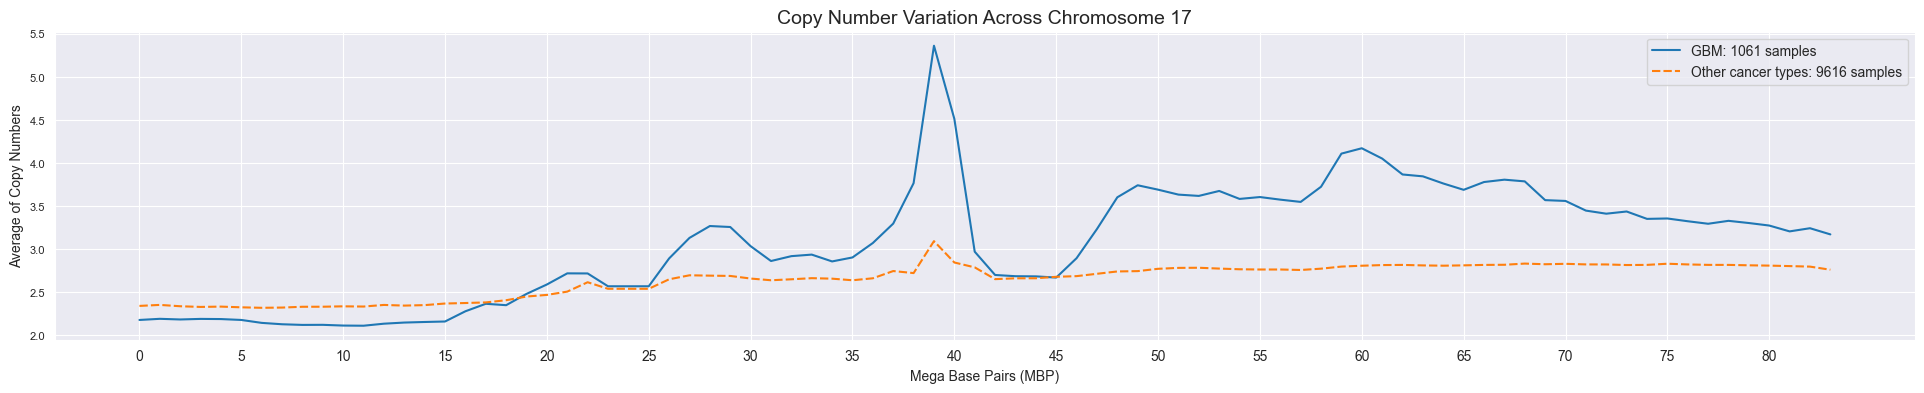

In [293]:
f = ind.chr.get_layer('CNVAR', groups={'Cancertype':'BRCA'}, chrom='chr17')
d = f['Cancertype:BRCA']['data']
nf = ind.chr.get_layer('CNVAR', groups={'Cancertype':'BRCA'}, chrom='chr17', reverse_filter=True)
nd = nf['Cancertype:BRCA']['data']
df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T]), index=[f'GBM: {d.shape[0]} samples', f'Other cancer types: {nd.shape[0]} samples']).T
plt.figure(figsize=(24, 4))
plt.title('Copy Number Variation Across Chromosome 17', fontsize=14)
plt.xlabel('Mega Base Pairs (MBP)')
plt.ylabel('Average of Copy Numbers')
plt.xticks(np.arange(0, d.shape[1], 5))
plt.yticks(fontsize=8)
sns.lineplot(df)
plt.savefig('BRCA_cnvar_chr17.png', bbox_inches='tight')
plt.show()

In [ ]:
f = ind.chr.get_layer('TCGA', groups={'cancertype':'BRCA'}, chrom='chr17')
d = f['Cancertype:BRCA']['data']
nf = ind.chr.get_layer('TCGA', groups={'cancertype':'BRCA'}, chrom='chr17', reverse_filter=True)
nd = nf['Cancertype:BRCA']['data']
df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T]), index=[f'GBM: {d.shape[0]} samples', f'Other cancer types: {nd.shape[0]} samples']).T
plt.figure(figsize=(24, 4))
plt.title('Chromatin Accessibility Across Chromosome 17', fontsize=14)
plt.xlabel('Mega Base Pairs (MBP)')
plt.ylabel('Average Number of Peaks with pvalue<=0.01')
plt.xticks(np.arange(0, d.shape[1], 5))
plt.yticks(fontsize=8)
sns.lineplot(df)
plt.savefig('BRCA_atac_chr17.png', bbox_inches='tight')
plt.show()

In [115]:
cdriver = pd.read_csv('/cluster/home/t124771uhn/data/OncoGenes/integrated_Unfiltered_drivers.tsv', sep='\t')

### TCGA dataset

<AxesSubplot: ylabel='normal_count'>

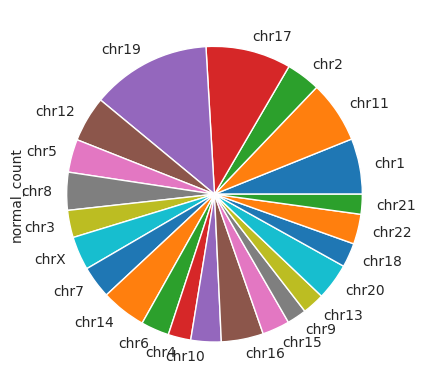

In [247]:
s = sub_cdriver['gene.chr'].value_counts()


v = pd.DataFrame.from_dict({'count':s.values, 'length':[ca.info.CHROMOSOMES['lens'].get(i) for i in s.index]})
v['normal_count'] = v['count']/v['length']
v.index = s.index
v['normal_count'].plot(kind='pie')

In [5]:
# tcga = pd.read_csv('/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', nrows=1, sep='\t')
tcga_meta = pd.read_csv('/cluster/home/t124771uhn/data/TCGA_ATAC/GDC_metadata.tsv', sep='\t')

In [21]:
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].values[0]}_{name}"

In [41]:
tcga_samples['samples']

0      5ef5359e-63e7-4706-938c-52b6195ba97d
1      945a9898-675f-47aa-a512-589ec4971313
2      e40a911f-8b1d-4cb4-940c-bc8bbee1b902
3      9f5bf096-2786-4025-b972-78d4bd94aed1
4      dca3c8e9-941f-4a1c-b5ac-b32c8c12ad74
                       ...                 
405    b47ecc02-8a99-4718-bd4f-411bb6a0bcda
406    fbf3a88f-5308-4234-874d-8a99e971efaa
407    5c661b28-3cdb-4dc0-b132-1e36543b267a
408    860c85db-e39e-4c94-a163-9f4e52ca1054
409    25a05c6e-6e41-4c0c-b5e8-07aa496d00ae
Name: samples, Length: 410, dtype: object

In [39]:
tcga_meta['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])

0      636f7eba6dd9
1      411bb6a0bcda
2      4573962637cf
3      00f013c81889
4      ce3edfaf4d6e
           ...     
405    182baa6ca7e1
406    43c5d2609950
407    50e997c0184a
408    cc4f5b404629
409    29a0b3be68a1
Name: File Name, Length: 410, dtype: object

In [14]:
tcga_met[' Project'].unique()

array(['TCGA-LUSC', 'TCGA-STAD', 'TCGA-LUAD', 'TCGA-PCPG', 'TCGA-COAD',
       'TCGA-KIRP', 'TCGA-BLCA', 'TCGA-HNSC', 'TCGA-ESCA', 'TCGA-PRAD',
       'TCGA-BRCA', 'TCGA-MESO', 'TCGA-TGCT', 'TCGA-UCEC', 'TCGA-SKCM',
       'TCGA-LIHC', 'TCGA-THCA', 'TCGA-LGG', 'TCGA-GBM', 'TCGA-KIRC',
       'TCGA-CHOL', 'TCGA-CESC', 'TCGA-ACC'], dtype=object)

In [6]:
# You have to select the cancer type then the samples from that cancer type will be loaded into a single Layer
CANCER_TYPE = 'TCGA-PRAD'

In [7]:
feature_columns = tcga_met['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga_samples['samples']])[0][0]).values

In [39]:
meta_encode = pd.read_csv("../data/experiment_report_2023_9_18_19h_36m.tsv", sep = '\t', skiprows= 1)

In [34]:
pd.read_csv('/Users/mossishahi/Code/lupien/IntData/data/encode/metadata.tsv', sep = '\t')

File accession        File format File type File format type  \
0       ENCFF367WGQ  bigBed narrowPeak    bigBed       narrowPeak   
1       ENCFF117WNZ     bed narrowPeak       bed       narrowPeak   
2       ENCFF745WUJ             bigWig    bigWig              NaN   
3       ENCFF849QYB             bigWig    bigWig              NaN   
4       ENCFF160DPC     bed narrowPeak       bed       narrowPeak   
...             ...                ...       ...              ...   
1372    ENCFF591HMI     bed narrowPeak       bed       narrowPeak   
1373    ENCFF467YWF  bigBed narrowPeak    bigBed       narrowPeak   
1374    ENCFF357GNC             bigWig    bigWig              NaN   
1375    ENCFF333TAT     bed narrowPeak       bed       narrowPeak   
1376    ENCFF086JCJ  bigBed narrowPeak    bigBed       narrowPeak   

                 Output type File assembly Experiment accession     Assay  \
0     pseudoreplicated peaks        GRCh38          ENCSR248ZAC  ATAC-seq   
1     pseudoreplicated peaks        GRCh38          ENCSR248ZAC  ATAC-seq   
2             signal p-value        GRCh38          ENCSR248ZAC  ATAC-seq   
3             signal p-value        GRCh38          ENCSR706GDQ  ATAC-seq   
4     pseudoreplicated peaks        GRCh38          ENCSR706GDQ  ATAC-seq   
...                      ...           ...                  ...       ...   
1372  pseudoreplicated peaks        GRCh38          ENCSR761TKU  ATAC-seq   
1373  pseudoreplicated peaks        GRCh38          ENCSR761TKU  ATAC-seq   
1374          signal p-value        GRCh38          ENCSR868FGK  ATAC-seq   
1375  pseudoreplicated peaks        GRCh38          ENCSR868FGK  ATAC-seq   
1376  pseudoreplicated peaks        GRCh38          ENCSR868FGK  ATAC-seq   

                        Donor(s) Biosample term id  ... Platform  \
0     /human-donors/ENCDO833KUM/        CL:0000899  ...      NaN   
1     /human-donors/ENCDO833KUM/        CL:0000899  ...      NaN   
2     /human-donors/ENCDO833KUM/        CL:0000899  ...      NaN   
3     /human-donors/ENCDO765HXB/       CLO:0026863  ...      NaN   
4     /human-donors/ENCDO765HXB/       CLO:0026863  ...      NaN   
...                          ...               ...  ...      ...   
1372  /human-donors/ENCDO451RUA/    UBERON:0001157  ...      NaN   
1373  /human-donors/ENCDO451RUA/    UBERON:0001157  ...      NaN   
1374  /human-donors/ENCDO000AAD/       EFO:0002067  ...      NaN   
1375  /human-donors/ENCDO000AAD/       EFO:0002067  ...      NaN   
1376  /human-donors/ENCDO000AAD/       EFO:0002067  ...      NaN   

     Controlled by File Status  \
0              NaN    released   
1              NaN    released   
2              NaN    released   
3              NaN    released   
4              NaN    released   
...            ...         ...   
1372           NaN    released   
1373           NaN    released   
1374           NaN    released   
1375           NaN    released   
1376           NaN    released   

                                                 s3_uri  \
0     s3://encode-public/2021/10/07/f396d97c-e3ad-4e...   
1     s3://encode-public/2021/10/07/8cdf9634-d837-44...   
2     s3://encode-public/2021/10/07/4cee3969-b935-4a...   
3     s3://encode-public/2021/01/26/af6d5431-8880-4c...   
4     s3://encode-public/2021/01/26/49ca5802-6040-49...   
...                                                 ...   
1372  s3://encode-public/2021/02/25/662e7d18-77d6-49...   
1373  s3://encode-public/2021/02/25/5e22d0dc-d32c-43...   
1374  s3://encode-public/2021/03/16/9ff8b5ae-10d6-47...   
1375  s3://encode-public/2021/03/16/f9c5229c-df01-48...   
1376  s3://encode-public/2021/03/16/92ef4967-0fc3-46...   

                                              Azure URL  \
0     https://datasetencode.blob.core.windows.net/da...   
1     https://datasetencode.blob.core.windows.net/da...   
2     https://datasetencode.blob.core.windows.net/da...   
3     https://datasetencode.blob.core.windows.net/da...   
4     https://dataset

In [44]:
meta_encode.columns

Index(['ID', 'Accession', 'Assay name', 'Assay title',
       'Biosample classification', 'Target', 'Target of assay',
       'Target gene symbol', 'Biosample summary', 'Biosample term name',
       'Dbxrefs', 'Description', 'Lab', 'Project', 'Status', 'Files',
       'Related series', 'Biosample accession', 'Biological replicate',
       'Technical replicate', 'Linked antibody', 'Organism', 'Life stage',
       'Biosample age', 'Biosample treatment',
       'Biosample treatment ontology ID', 'Biosample treatment amount',
       'Biosample treatment amount units', 'Biosample treatment duration',
       'Biosample treatment duration units', 'Synchronization',
       'Post-synchronization time', 'Post-synchronization time units',
       'Biosample modification site target organism',
       'Biosample modification site introduced gene organism', 'Replicates',
       'Mixed biosamples', 'Cellular component',
       'Library construction platform', 'Library construction method'],
      dtyp

In [56]:
meta_encode['Biosample term name']=='pro

0                   erythroblast
1                        HG02870
2      erythroid progenitor cell
3                        GM21717
4                        HG02759
                 ...            
454                      stomach
455                      GM19467
456                         K562
457                         PC-3
458                        Panc1
Name: Biosample term name, Length: 459, dtype: object

In [63]:
df = os.listdir('/cluster/projects/lupiengroup/People/mossi/data/encode/bedfiles')

In [64]:
np.where([i.split('.bed.gz')[0] in meta_encode.iloc[440, :]['Files'] for i in df])

(array([319]),)

In [65]:
df[319]

'ENCFF030AIT.bed.gz'

In [61]:
meta_encode.iloc[440, :]['Files']

'/files/ENCFF598USO/,/files/ENCFF527XCY/,/files/ENCFF670GFY/,/files/ENCFF492NWI/,/files/ENCFF644FYW/,/files/ENCFF332DEJ/,/files/ENCFF030AIT/,/files/ENCFF923YNJ/,/files/ENCFF592AOH/,/files/ENCFF346EDM/,/files/ENCFF678CZL/,/files/ENCFF358ZBP/,/files/ENCFF963ISM/,/files/ENCFF194LAU/'

In [57]:
np.where(meta_encode['Biosample term name']=='prostate gland')

(array([440]),)

In [24]:
CANCER_TYPE = 'TCGA-BRCA'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [08:41<00:00, 28.5MB/s]


In [36]:
[np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns]) for x in tcga_met[tcga_met[' Project']=='TCGA-PRAD']['File Name']]

[(array([99]),),
 (array([131]),),
 (array([30]),),
 (array([127]),),
 (array([321]),),
 (array([364]),),
 (array([130]),),
 (array([229]),),
 (array([356]),),
 (array([8]),),
 (array([260]),),
 (array([245]),),
 (array([239]),),
 (array([322]),),
 (array([11]),),
 (array([259]),),
 (array([177]),),
 (array([194]),),
 (array([132]),),
 (array([107]),),
 (array([22]),),
 (array([238]),),
 (array([166]),),
 (array([277]),),
 (array([192]),),
 (array([122]),)]

In [38]:
tcga.iloc[:, 131]

0    2.643788
Name: ..mapbed.4aea1c7f.4b8b.4416.9bd1.9608a8ccd1a4, dtype: float64

In [27]:
tcga_met[tcga_met[' Project']=='TCGA-PRAD']

Unnamed: 0                             File UUID      Access  \
18           18  116da124-800a-475c-b400-d8dcfbd39259  controlled   
31           31  15c811bc-dc24-4066-a015-5eea14ad5cbb  controlled   
60           60  dfccde08-c374-4ec6-ba86-81b79a69e708  controlled   
77           77  8424c5b0-272e-490c-b6f8-06f08969fcd6  controlled   
78           78  1f72cd05-d9e5-4fed-b8b1-a7511eb7ea1b  controlled   
111         111  d7a97dcb-a1b6-4079-98ff-ad316c1f798a  controlled   
117         117  909155ec-5e87-4468-9032-16df8107052b  controlled   
192         192  1130ac7b-19d9-4e14-b1ba-4da6f37e9a31  controlled   
196         196  e3e4e7ac-8d18-4545-b7fd-5b48ba0ae3d2  controlled   
219         219  caf51b3e-41a4-42a7-86df-f243a4b764a1  controlled   
220         220  0f70ac1d-fc5e-4548-bf4f-2c9b6e70e18a  controlled   
229         229  5660b92f-2b0c-4328-9555-6db047dab9dd  controlled   
230         230  a64f8325-5b3b-4570-b34b-ad50a27a9a2b  controlled   
242         242  a9d4d494-d0cf-4c8f-8242-b328a4ebf977  controlled   
256         256  18679868-c1de-41cd-b37c-688e81d2f3ab  controlled   
257         257  99d713b7-33aa-49cd-9562-9804db55512a  controlled   
274         274  c4c1120a-6c58-4e61-929f-7029c2598e77  controlled   
275         275  8c56b616-9623-4732-a5e9-b2b10d2180f9  controlled   
276         276  92de0a3a-73eb-4ff9-9508-683e33da3e5f  controlled   
277         277  1a128f47-a6af-45ad-bb8c-310f9fa917d5  controlled   
281         281  7aec013b-eab3-452b-8a79-12b236b7687c  controlled   
282         282  4d35dfa7-3f30-4ab1-898d-091bf223ad29  controlled   
283         283  a99826fd-c437-49d6-8ca4-415f01f04a10  controlled   
284         284  f50f6a6a-c301-4ff1-8b43-f20ee2ba86b7  controlled   
321         321  537f7924-98df-4d84-9df7-0f7a42756dd8  controlled   
394         394  594f700b-6aaf-43a0-a470-e193553963f9  controlled   

                                             File Name  Cases    Project  \
18   385e16fd-bb65-4846-86e2-208e0548987a_atacseq_g...      1  TCGA-PRAD   
31   4aea1c7f-4b8b-4416-9bd1-9608a8ccd1a4_atacseq_g...      1  TCGA-PRAD   
60   1218f3be-8113-4717-9000-c4fb6a2190a8_atacseq_g...      1  TCGA-PRAD   
77   4624c3e9-8517-4162-a248-c866a8571e07_atacseq_g...      1  TCGA-PRAD   
78   c5279a97-093e-480d-9f4e-7ccf495b8a72_atacseq_g...      1  TCGA-PRAD   
111  e2995496-be9a-4ca7-a604-e489da4a071e_atacseq_g...      1  TCGA-PRAD   
117  49bf2f15-d137-43dd-b648-df8aa7a1861a_atacseq_g...      1  TCGA-PRAD   
192  880952ef-b249-4837-ae1f-4824eb0d12a2_atacseq_g...      1  TCGA-PRAD   
196  dcbf2327-ced8-478e-8da0-b725df1a08f6_atacseq_g...      1  TCGA-PRAD   
219  02f56cb3-dc15-4dbd-a508-cbb14154e1bd_atacseq_g...      1  TCGA-PRAD   
220  979bf6e5-92ad-4c28-bba9-7c52c6545996_atacseq_g...      1  TCGA-PRAD   
229  8fa9fcfc-9e6a-4f7f-b590-2d717c0da587_atacseq_g...      1  TCGA-PRAD   
230  8c128110-4bf4-4ede-9361-c39be9c2f275_atacseq_g...      1  TCGA-PRAD   
242  c64aa0ca-3d36-4823-bd4c-669cd6aa3129_atacseq_g...      1  TCGA-PRAD   
256  03d0944c-b853-4b09-bd82-5db368275033_atacseq_g...      1  TCGA-PRAD   
257  974f10e4-67b3-40c6-a2be-21149c884ead_atacseq_g...      1  TCGA-PRAD   
274  672b6f7c-a338-4f90-b7e6-f01ec16c6c82_atacseq_g...      1  TCGA-PRAD   
275  71d656e2-ad6b-4d57-9a1c-137154f7945e_atacseq_g...      1  TCGA-PRAD   
276  4b26a8e2-d47e-45fa-b227-448a329d47f0_atacseq_g...      1  TCGA-PRAD   
277  3e3c596d-f89c-40d2-84d8-db5f58d49860_atacseq_g...      1  TCGA-PRAD   
281  0a90e0af-e61c-4270-b2af-443df8f6b04b_atacseq_g...      1  TCGA-PRAD   
282  8bf15ccb-5824-4e3d-9c4b-73fec8e78e2e_atacseq_g...      1  TCGA-PRAD   
283  63db8645-7165-4f35-8dc1-8d5559b7b258_atacseq_g...      1  TCGA-PRAD   
284  a43f1278-b3e6-4df4-90ec-446a98b87b51_atacseq_g...      1  TCGA-PRAD   
321  7082afcf-d091-47e0-9265-6caf609c1a1e_atacseq_g...      1  TCGA-PRAD   
394  44524003-7e35-4582-b5d7-d735a06fee54_atacseq_g...      1  TCGA-PRAD   

        Data Category Data Format File Size  Annotations  \
18   Sequencing Reads       

In [58]:
CANCER_TYPE = 'TCGA-LUAD'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [04:09<00:00, 59.7MB/s]


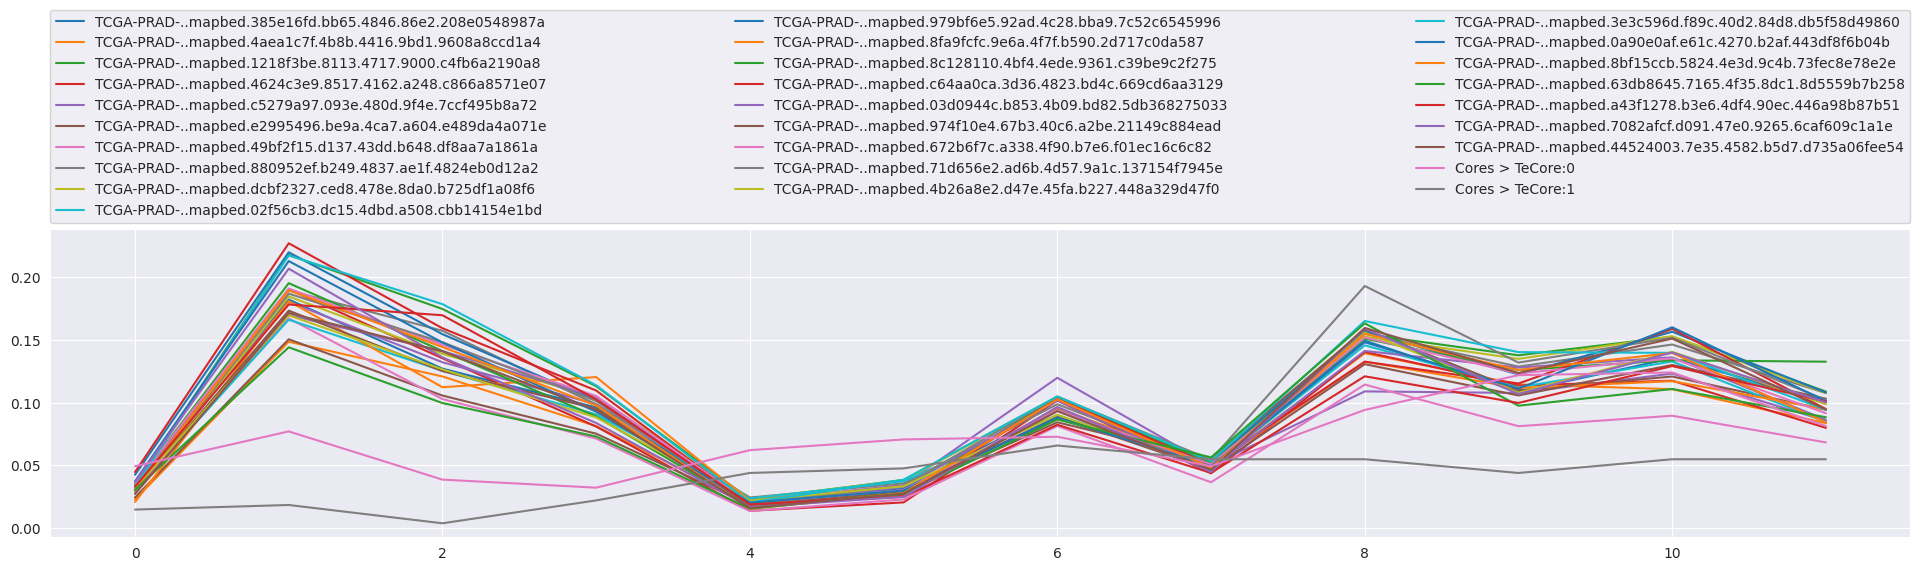

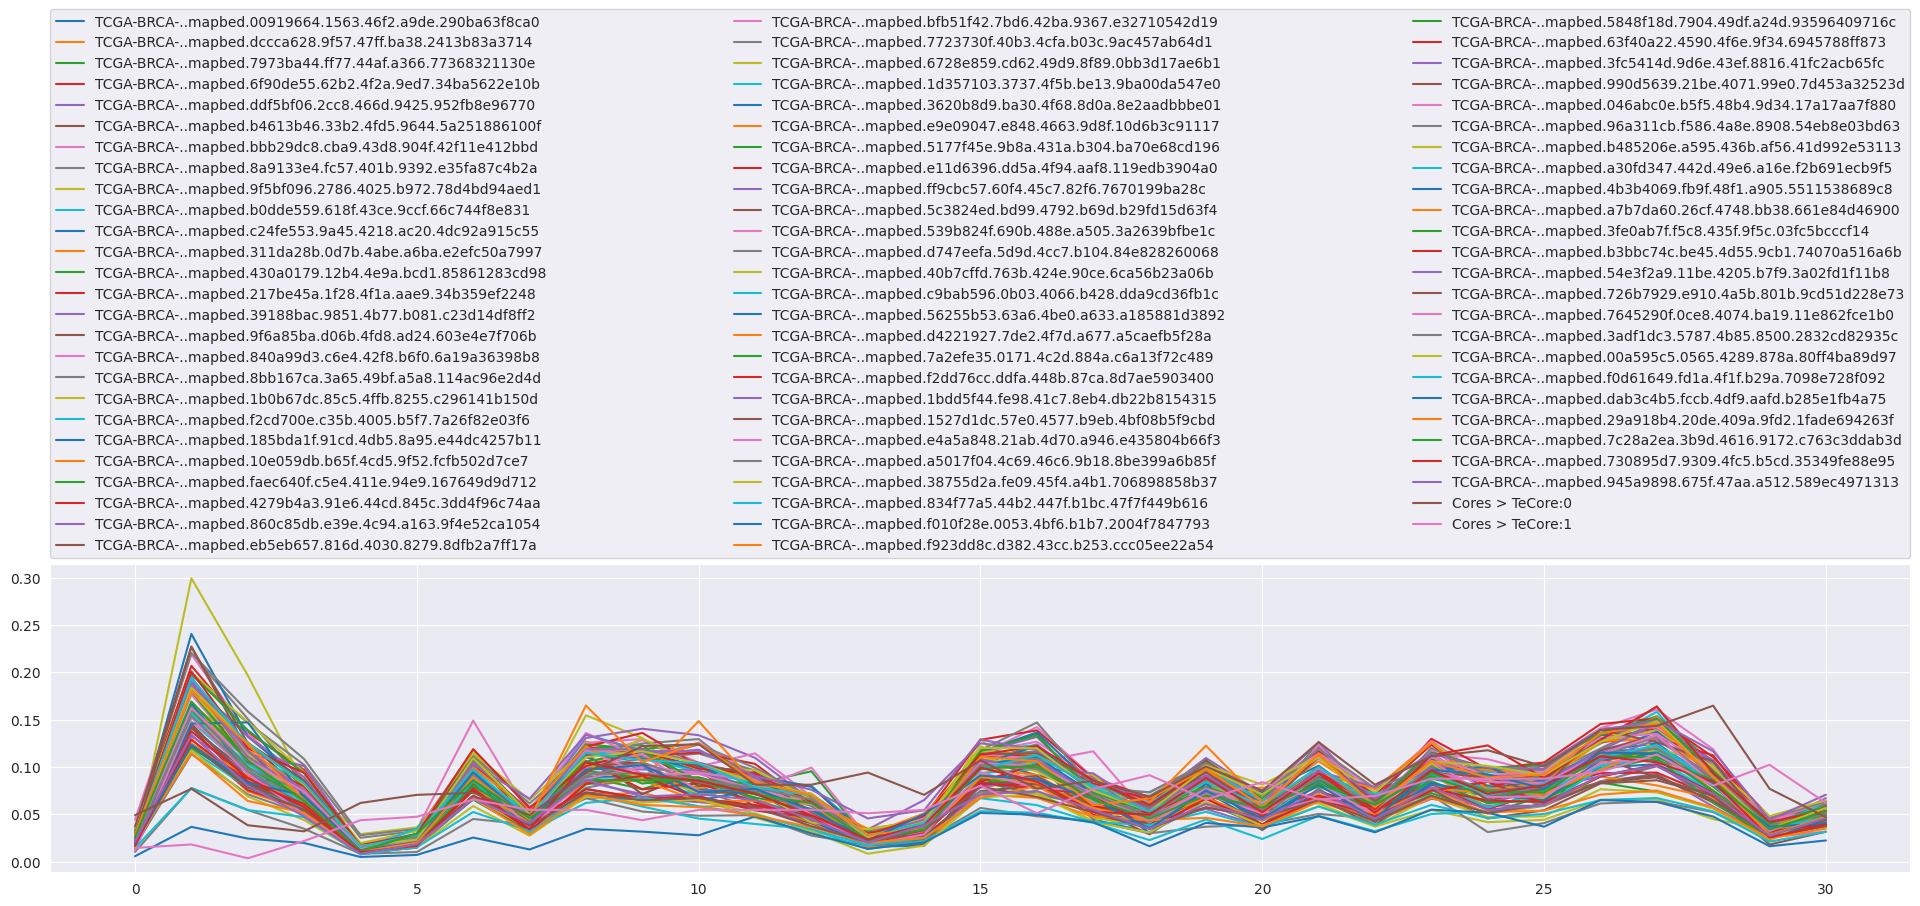

In [56]:
CHR = 'chr1'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-BRCA')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)

In [62]:
CHR = 'chrX'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e07)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-LUAD')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e07)

KeyError: 'TCGA-PRAD-..mapbed.385e16fd.bb65.4846.86e2.208e0548987a'

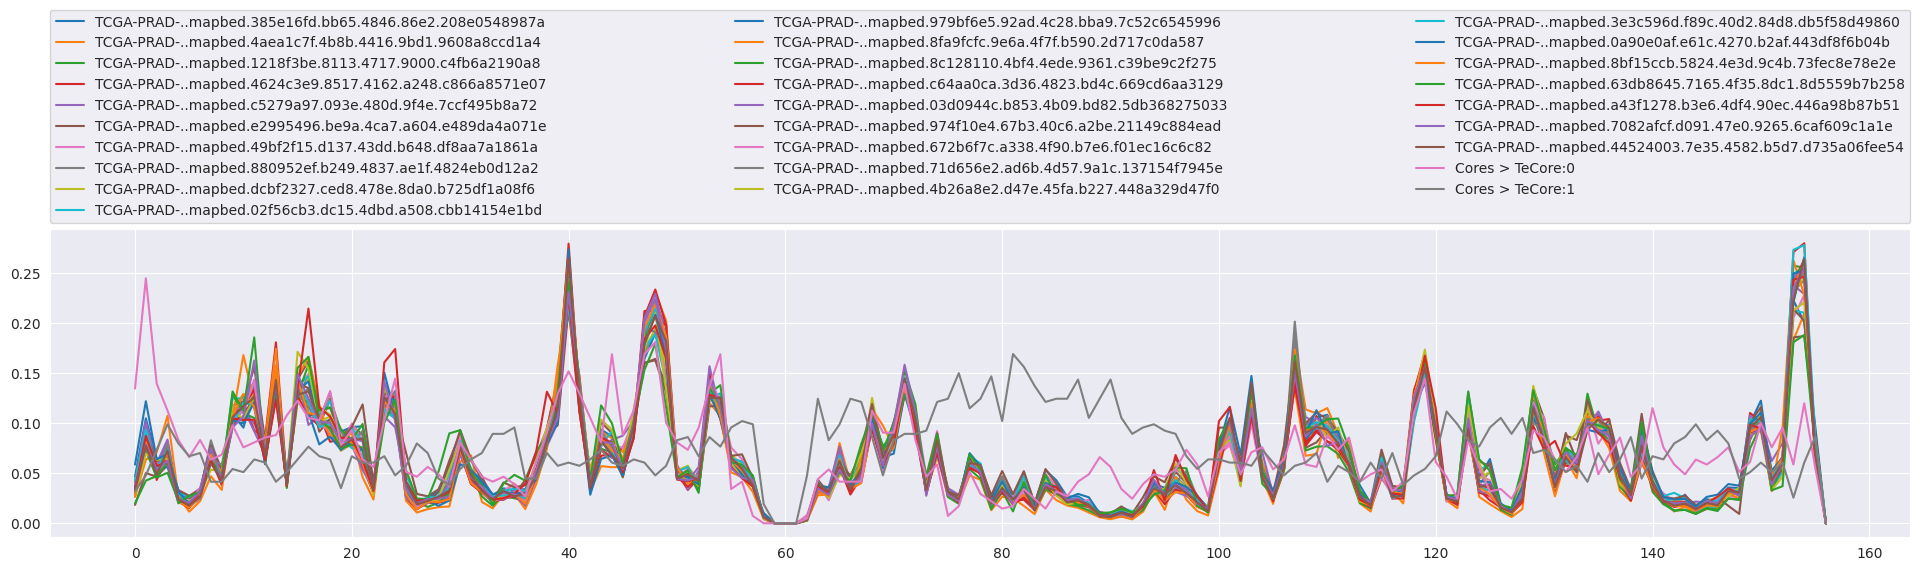

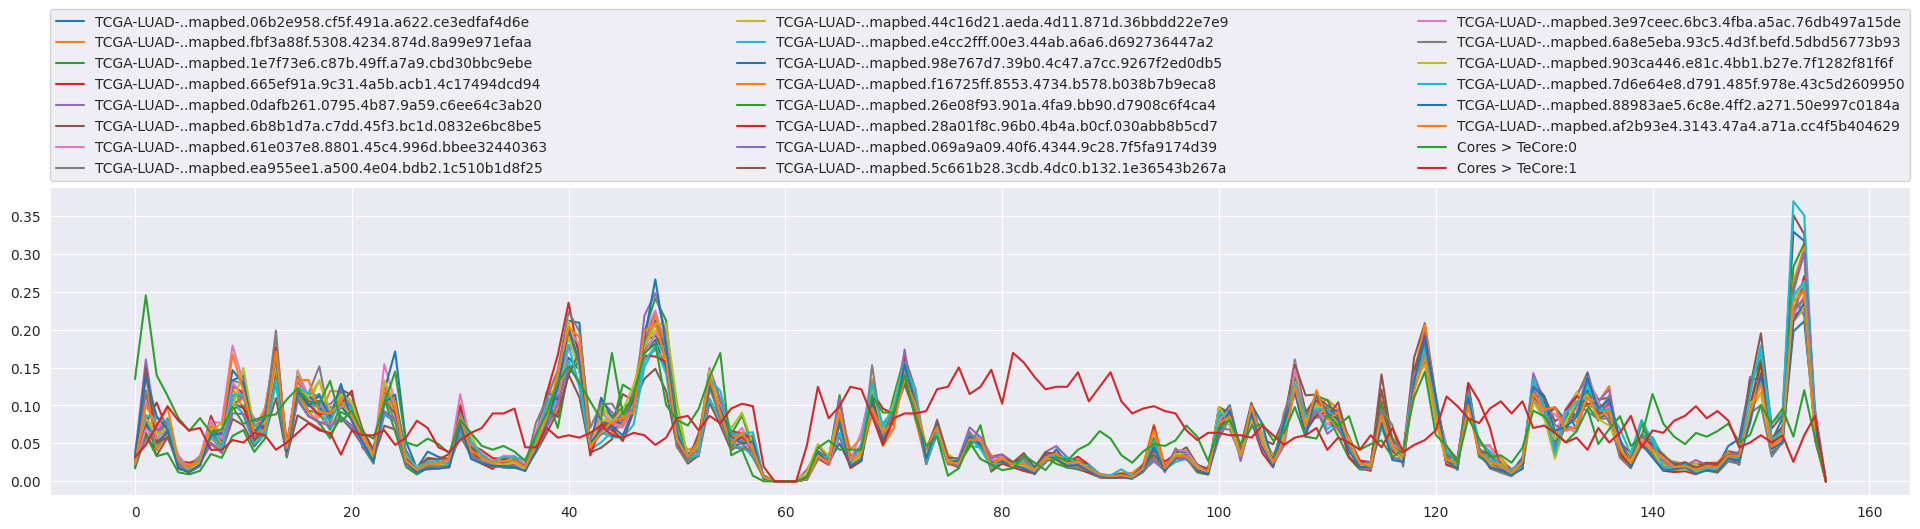

In [61]:
CHR = 'chrX'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-LUAD')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06)

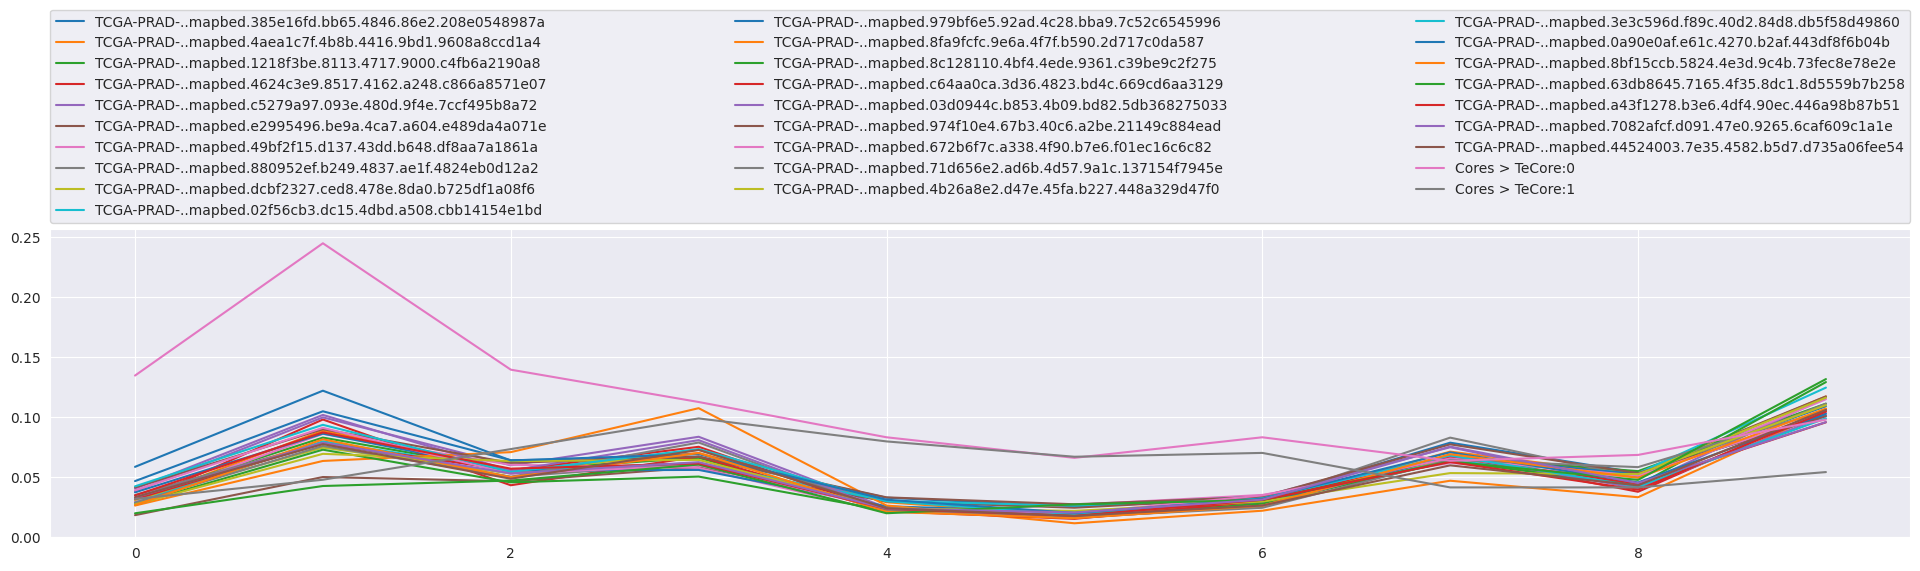

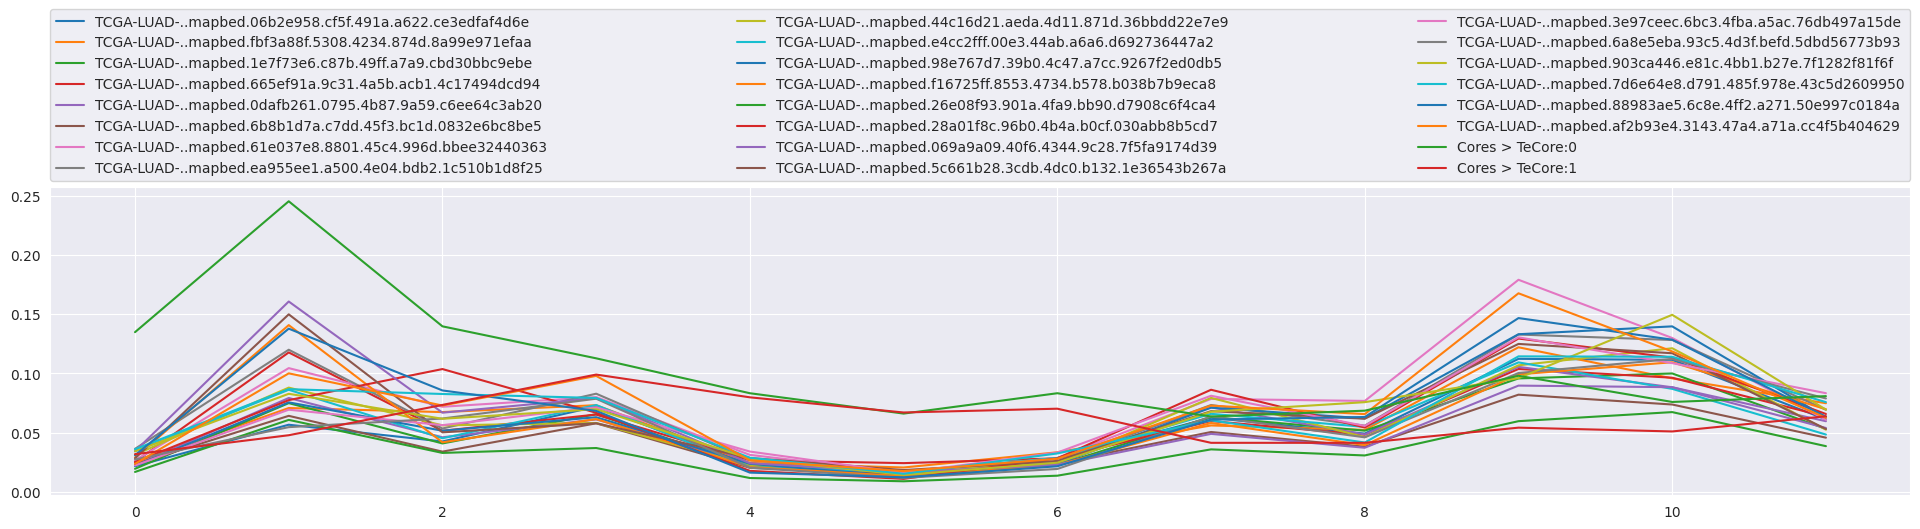

In [59]:
CHR = 'chrX'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-LUAD')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)

## Add Filters

In [39]:
ind.genome.differentiate_layers(['TEs', 'Cores'], scale=True, resolution='chr')

In [47]:
outliers = ca.al.identify_outliers(ind.genome.layers['chr']['Cores-TEs'], axis=0, signed=True, return_value=True)

In [48]:
test_res = outliers['total']
index = ind.genome.layers['chr']['Cores-TEs']['index']

In [49]:
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    for chr in range(1, 25):
        idx = kwargs.get('index')[kwargs.get('test_res')[:, chr-1]>=kwargs.get('majority', 3)]
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [50]:
def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    for chr in range(1, 25):
        idx = kwargs.get('index')[kwargs.get('test_res')[:, chr-1]>=kwargs.get('majority', 3)]
        conditions[chr] = np.array([int(i in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

In [51]:
ind.chr.add_filter('TeCore', CTeCore_filter, layers = ['TEs', 'Cores'], index=index, test_res=test_res, resolution=1e06)
ind.genome.add_filter('TeCore', GTeCore_filter, layers = ['TEs', 'Cores', 'Cores-TEs'], index=index, test_res=test_res, resolution=1e06)

In [55]:
ind.add_layer('Encode', input='/cluster/projects/lupiengroup/People/mossi/data/encode/bedfiles', feature_columns=[6], file_format='gz', feature_type='signal')

loading files from: /cluster/projects/lupiengroup/People/mossi/data/encode/bedfiles


100%|██████████| 460/460 [07:36<00:00,  1.01it/s]


In [63]:
RESOLUTION = 1e07

In [64]:
ind.add_layer("TEs", input='/cluster/home/t124771uhn/data/V2-TEs/non_olap/', resolution=RESOLUTION)

loading files from: /cluster/home/t124771uhn/data/V2-TEs/non_olap/


100%|██████████| 975/975 [00:24<00:00, 39.03it/s]


### Number of CREAM Cores

In [65]:
ind.add_layer("Cores", input='/cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/', resolution=RESOLUTION)

loading files from: /cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/


100%|██████████| 455/455 [00:00<00:00, 477.39it/s]


In [66]:
tcga = pd.read_csv('/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', nrows=1, sep='\t')
tcga_met = pd.read_csv('/cluster/home/t124771uhn/data/TCGA_ATAC/GDC_metadata.tsv', sep='\t')

In [67]:
tcga_met[' Project'].unique()

array(['TCGA-LUSC', 'TCGA-STAD', 'TCGA-LUAD', 'TCGA-PCPG', 'TCGA-COAD',
       'TCGA-KIRP', 'TCGA-BLCA', 'TCGA-HNSC', 'TCGA-ESCA', 'TCGA-PRAD',
       'TCGA-BRCA', 'TCGA-MESO', 'TCGA-TGCT', 'TCGA-UCEC', 'TCGA-SKCM',
       'TCGA-LIHC', 'TCGA-THCA', 'TCGA-LGG', 'TCGA-GBM', 'TCGA-KIRC',
       'TCGA-CHOL', 'TCGA-CESC', 'TCGA-ACC'], dtype=object)

In [68]:
# You have to select the cancer type then the samples from that cancer type will be loaded into a single Layer
CANCER_TYPE = 'TCGA-PRAD'

In [69]:
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [03:45<00:00, 66.0MB/s]


In [70]:
CANCER_TYPE = 'TCGA-BRCA'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [09:09<00:00, 27.1MB/s]


In [71]:
CANCER_TYPE = 'TCGA-LUAD'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [03:18<00:00, 75.1MB/s]


In [91]:
ind.chr.layers[1e06].keys()

odict_keys(['TEs', 'Cores', 'TCGA'])

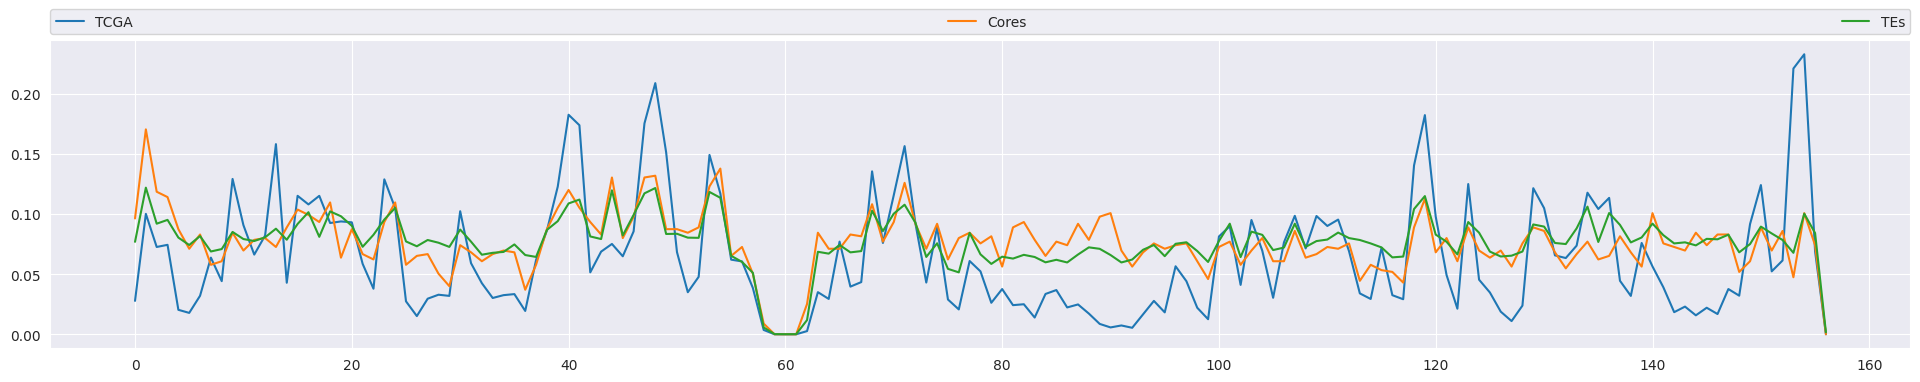

In [94]:
ca.pl.match_layers(ind.chr, ['TCGA', 'Cores', 'TEs'], chr=23, resolution=1e06, reduce_dim=True)